# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down. 

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a wind turbine where there is no detection by model. 
- False positives (FP) are detections in a wind turbine where there is no failure. 

So, the maintenance cost associated with the model would be:

**Maintenance cost** = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
where,

- `Replacement cost = $40,000`
- `Repair cost = $15,000`
- `Inspection cost = $5,000`

Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

- The minimum possible maintenance cost  =  `Actual failures*(Repair cost) = (TP + FN)*(Repair cost)`
- The maintenance cost associated with model = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`

So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [38]:
# To help with reading and manipulating data
import time
import threading
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Loading Data

In [3]:
#importing the training dataset
traindata = pd.read_csv("Rewind-Train.csv")

<IPython.core.display.Javascript object>

In [4]:
#importing the test dataset
testdata = pd.read_csv("Rewind-Test.csv")

<IPython.core.display.Javascript object>

## EDA and insights

In [5]:
#Shape of the data 
traindata.shape

(40000, 41)

<IPython.core.display.Javascript object>

In [6]:
testdata.shape

(10000, 41)

<IPython.core.display.Javascript object>

* The train dataset has 40000 rows and 41 columns.
* The test dataset has 10000 rows and 41 columns.


In [7]:
# let's view the first 5 rows of the data
traindata.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,-2.910,-2.569,4.109,1.317,-1.621,-3.827,-1.617,0.669,0.387,0.854,-6.353,4.272,3.162,0.258,-3.547,-4.285,2.897,1.508,3.668,7.124,-4.096,1.015,-0.970,-0.968,2.064,-1.646,0.427,0.735,-4.470,-2.772,-2.505,-3.783,-6.823,4.909,0.482,5.338,2.381,-3.128,3.527,-3.020,0
2,4.284,5.105,6.092,2.640,-1.041,1.308,-1.876,-9.582,3.470,0.763,-2.573,-3.350,-0.595,-5.247,-4.310,-16.232,-1.000,2.318,5.942,-3.858,-11.599,4.021,-6.281,4.633,0.930,6.280,0.851,0.269,-2.206,-1.329,-2.399,-3.098,2.690,-1.643,7.566,-3.198,-3.496,8.105,0.562,-4.227,0
3,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
4,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0


<IPython.core.display.Javascript object>

In [8]:
# let's view the last 5 rows of the data
traindata.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
39995,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
39996,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
39997,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0
39998,0.521,0.096,8.457,2.138,-1.636,-2.713,-2.693,-3.410,1.936,2.012,-4.989,-0.819,4.166,-1.192,-5.033,-8.523,-1.950,0.017,4.505,2.031,-8.849,0.566,-6.040,-0.043,1.656,4.250,1.727,-1.686,-3.963,-2.642,1.939,-1.257,-1.136,1.434,5.905,3.752,-1.867,-1.918,2.573,-5.019,0
39999,2.403,-1.336,6.451,-5.356,-0.434,0.255,-1.120,-2.523,-0.654,2.316,-2.862,0.199,1.593,-0.337,-0.709,-4.408,-3.683,2.973,-1.223,-1.958,-4.454,0.464,-4.952,-1.624,2.965,2.009,5.712,-2.910,-2.287,-3.676,5.678,-4.310,-0.709,-1.359,1.639,7.766,-0.245,-1.124,2.872,1.902,0


<IPython.core.display.Javascript object>

In [9]:
# let's check the data types of the columns in the dataset
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

<IPython.core.display.Javascript object>

* All columns are numerical in nature. 

In [10]:
# let's check for missing values in the train data
traindata.isnull().sum() 

V1        46
V2        39
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

<IPython.core.display.Javascript object>

In [11]:
# let's check for missing values in the test data
testdata.isnull().sum() 

V1        11
V2         7
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

<IPython.core.display.Javascript object>

In [12]:
# let's view the statistical summary of the numerical columns in the data
traindata.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,39954.000,-0.288,3.449,-13.502,-2.751,-0.774,1.837,17.437
V2,39961.000,0.443,3.139,-13.212,-1.638,0.464,2.538,13.089
V3,40000.000,2.506,3.406,-11.469,0.203,2.265,4.585,18.366
V4,40000.000,-0.066,3.437,-16.015,-2.350,-0.124,2.149,13.280
V5,40000.000,-0.045,2.107,-8.613,-1.507,-0.097,1.346,9.403
V6,40000.000,-1.001,2.037,-10.227,-2.363,-1.007,0.374,7.065
V7,40000.000,-0.893,1.757,-8.206,-2.037,-0.935,0.207,8.006
V8,40000.000,-0.563,3.299,-15.658,-2.660,-0.384,1.714,11.679
V9,40000.000,-0.008,2.162,-8.596,-1.494,-0.052,1.426,8.507
V10,40000.000,-0.002,2.183,-11.001,-1.391,0.106,1.486,8.108


<IPython.core.display.Javascript object>

In [13]:
# let's check for duplicate values in the data
traindata.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [14]:
# let's check for duplicate values in the data
testdata.duplicated().sum()

0

<IPython.core.display.Javascript object>

* V1 and V2 has missing values in train and in test data. 
* There are no duplicate data in train and test dataset. 

### Univariate analysis


In [15]:
## lets make a copy of the original train data.
copy_train = traindata.copy()

<IPython.core.display.Javascript object>

In [16]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

### Univariate analysis

<Figure size 720x360 with 0 Axes>

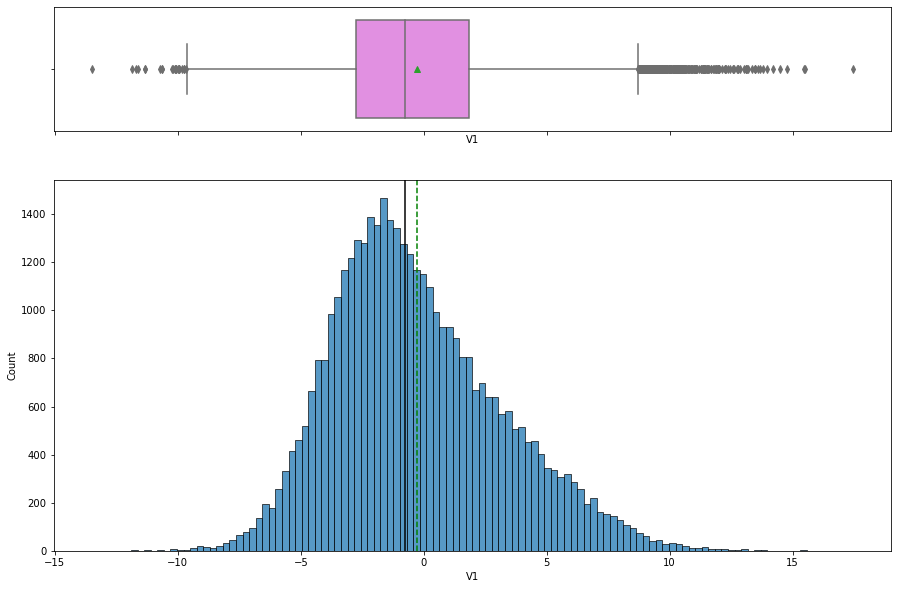

<Figure size 720x360 with 0 Axes>

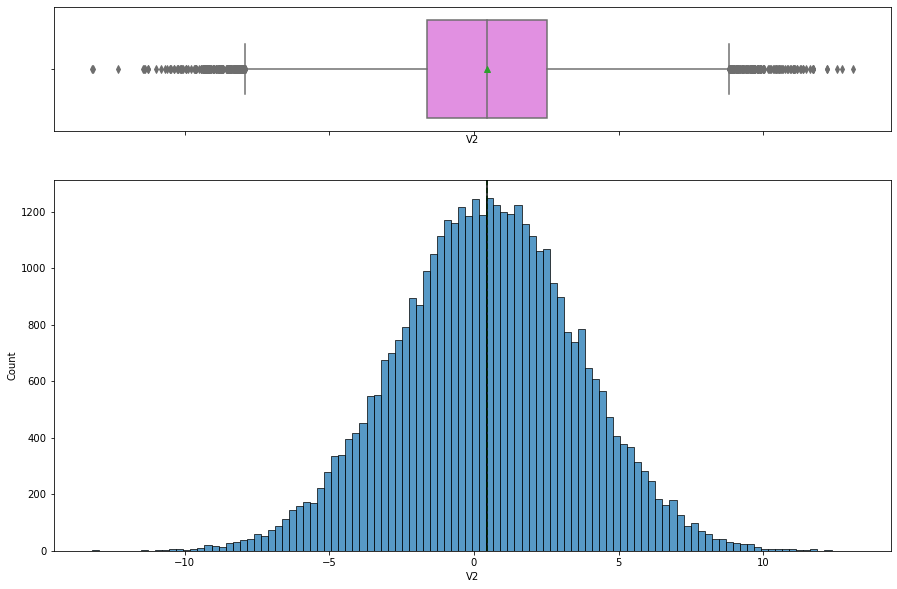

<Figure size 720x360 with 0 Axes>

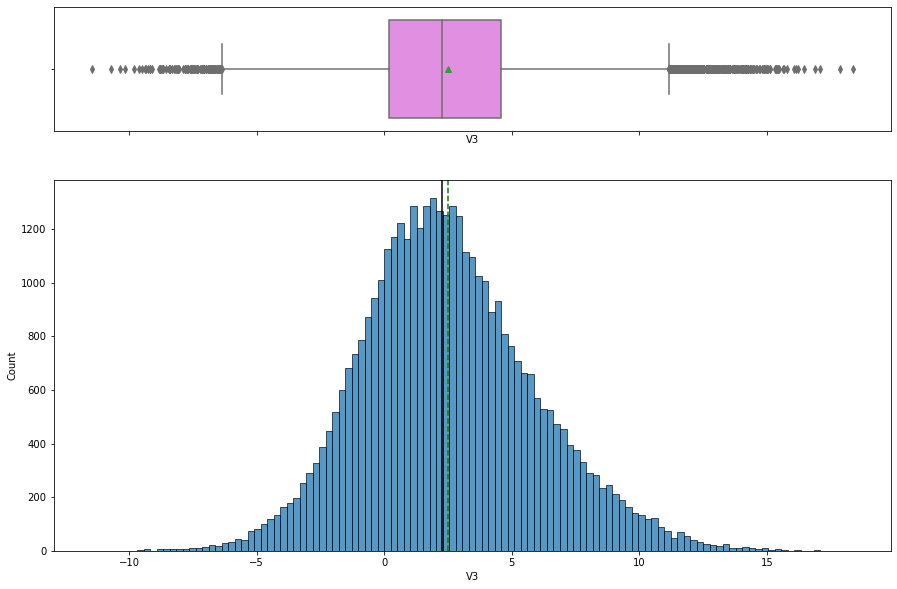

<Figure size 720x360 with 0 Axes>

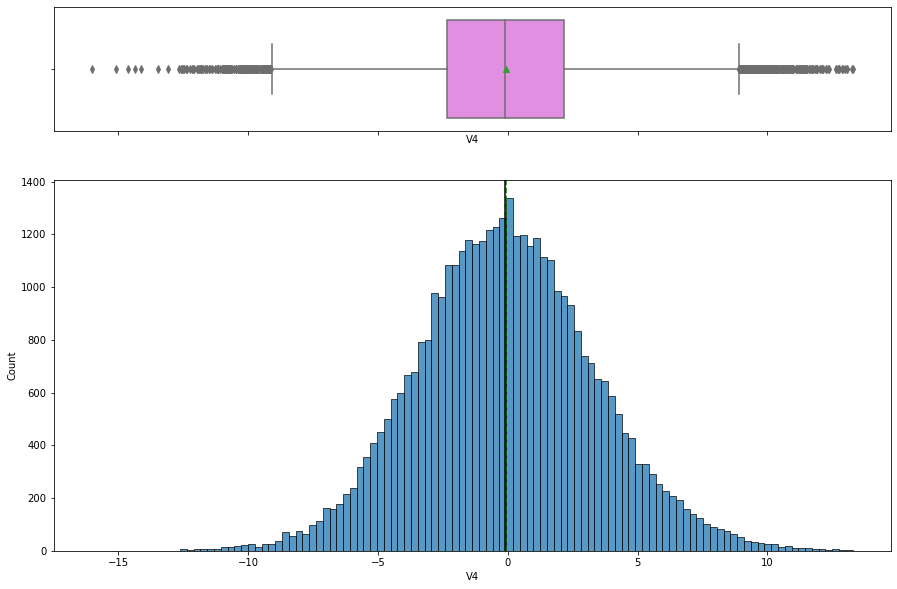

<Figure size 720x360 with 0 Axes>

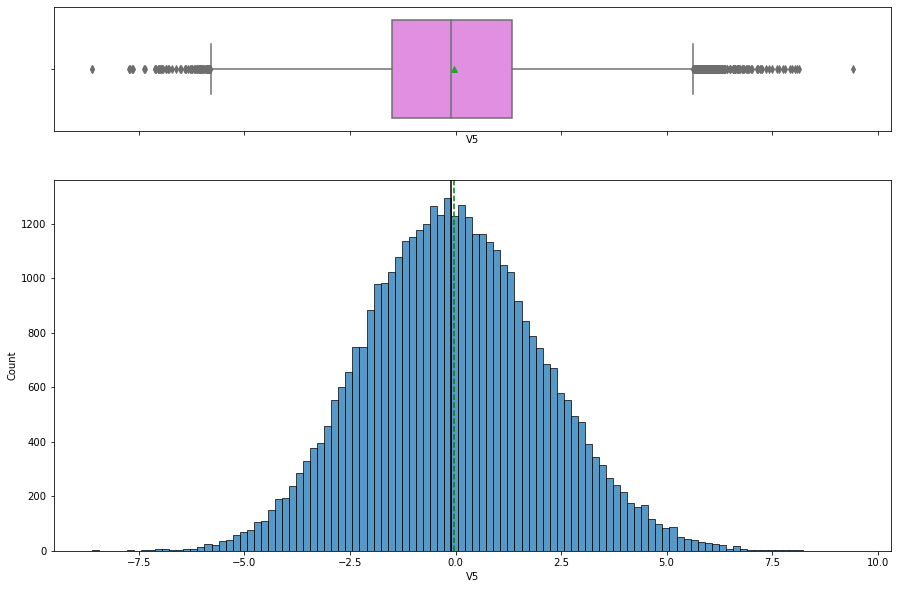

<Figure size 720x360 with 0 Axes>

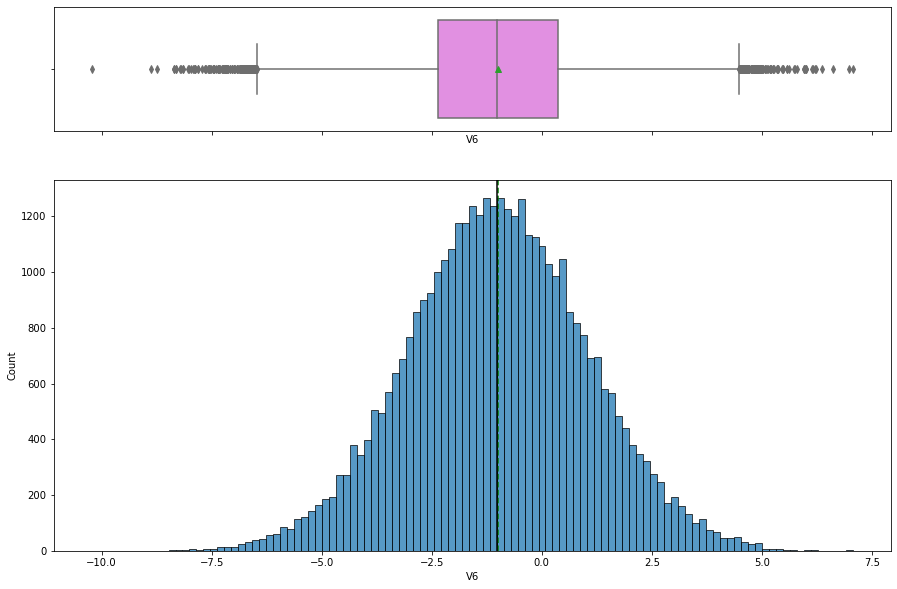

<Figure size 720x360 with 0 Axes>

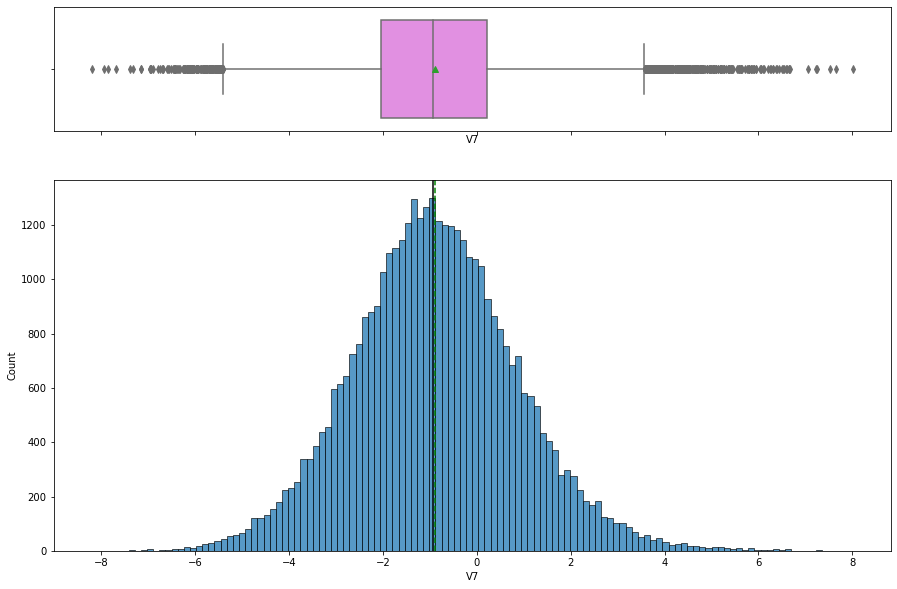

<Figure size 720x360 with 0 Axes>

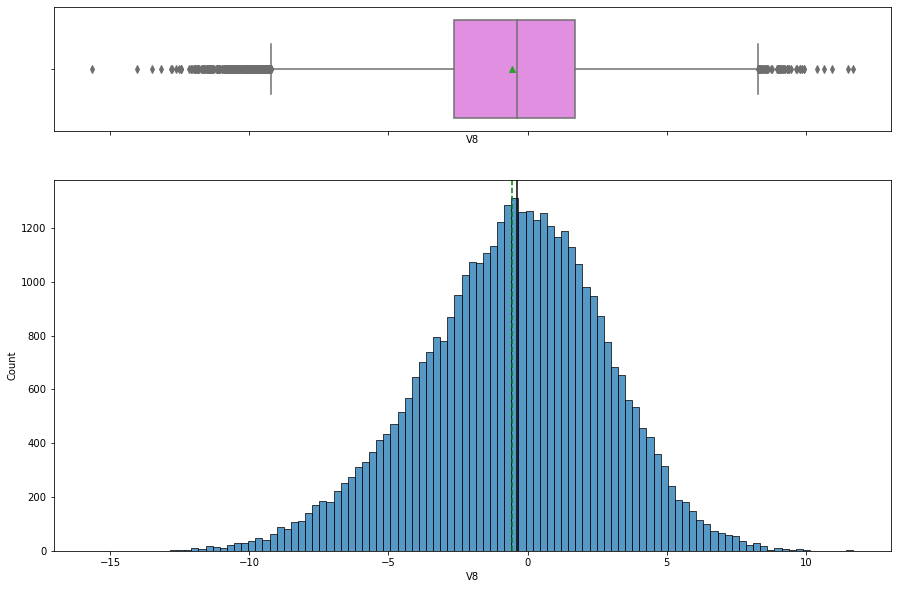

<Figure size 720x360 with 0 Axes>

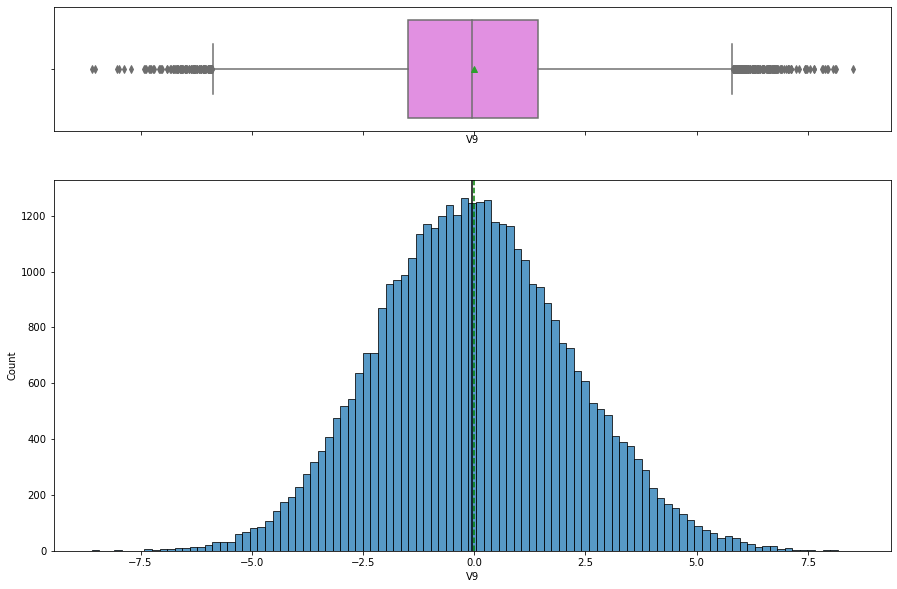

<Figure size 720x360 with 0 Axes>

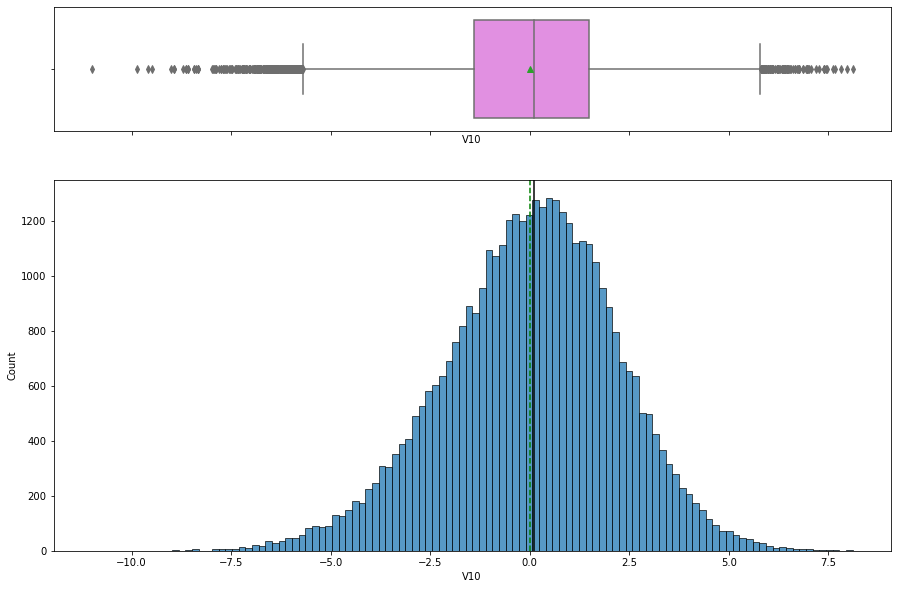

<Figure size 720x360 with 0 Axes>

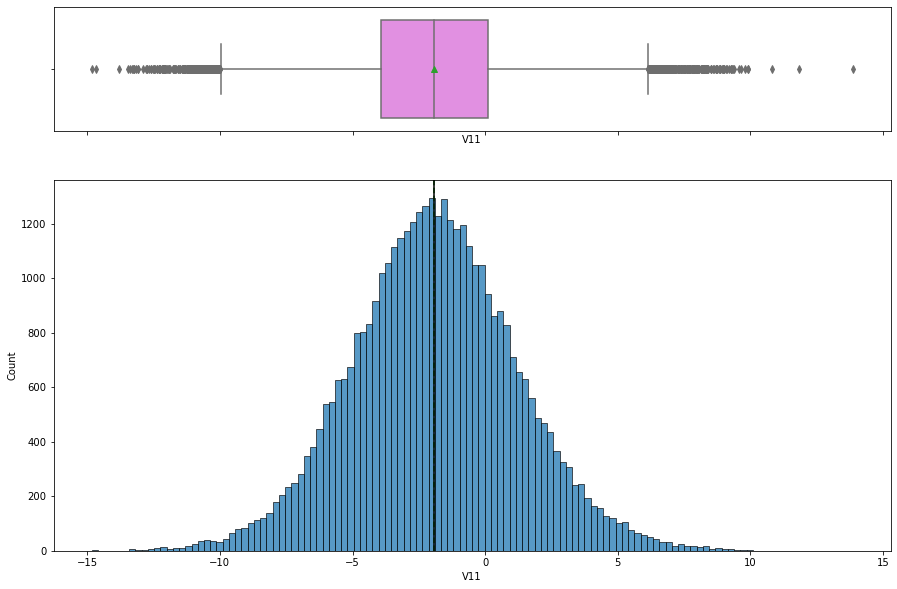

<Figure size 720x360 with 0 Axes>

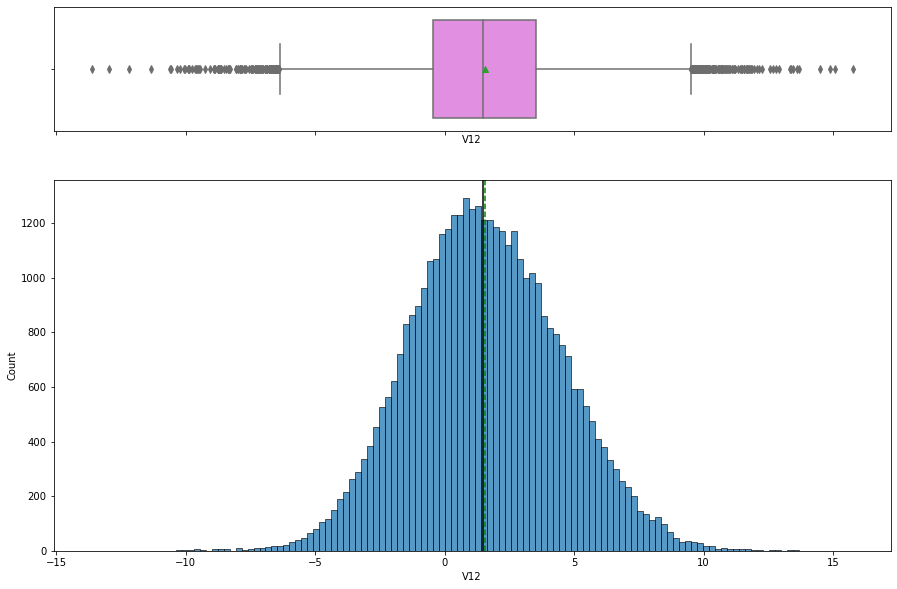

<Figure size 720x360 with 0 Axes>

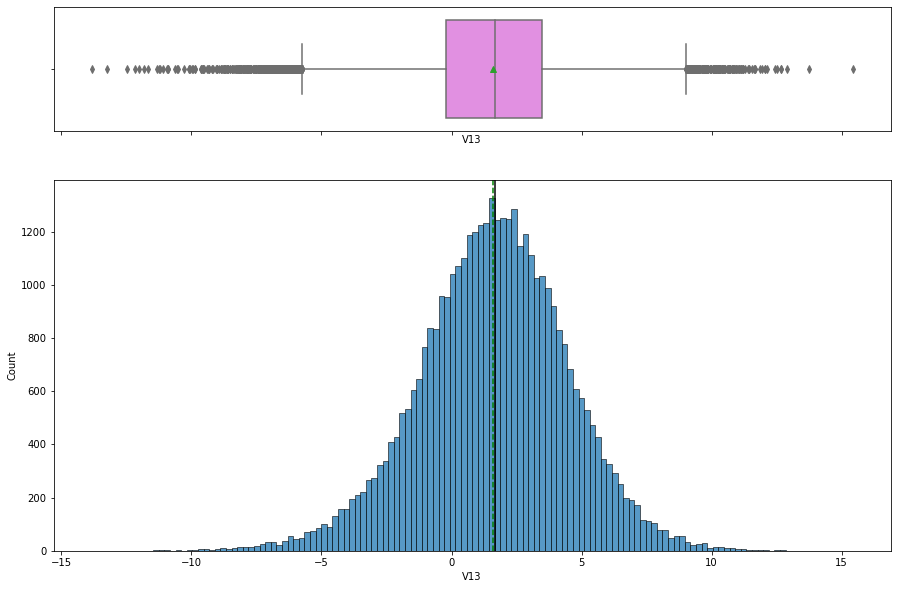

<Figure size 720x360 with 0 Axes>

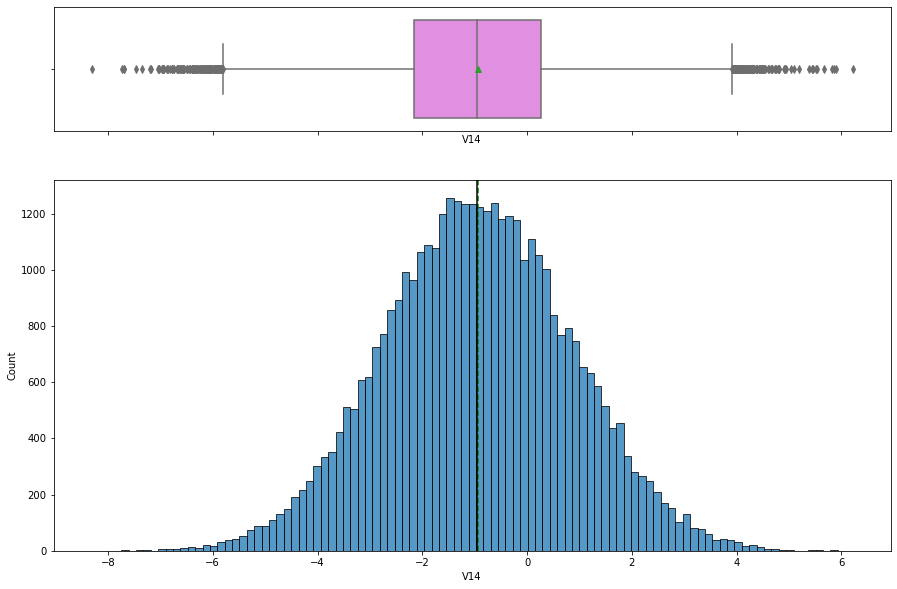

<Figure size 720x360 with 0 Axes>

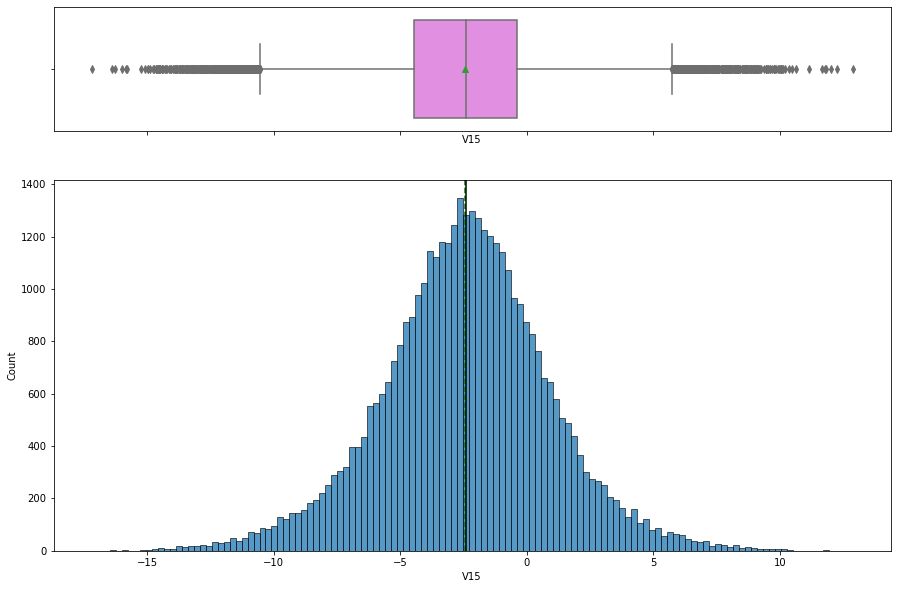

<Figure size 720x360 with 0 Axes>

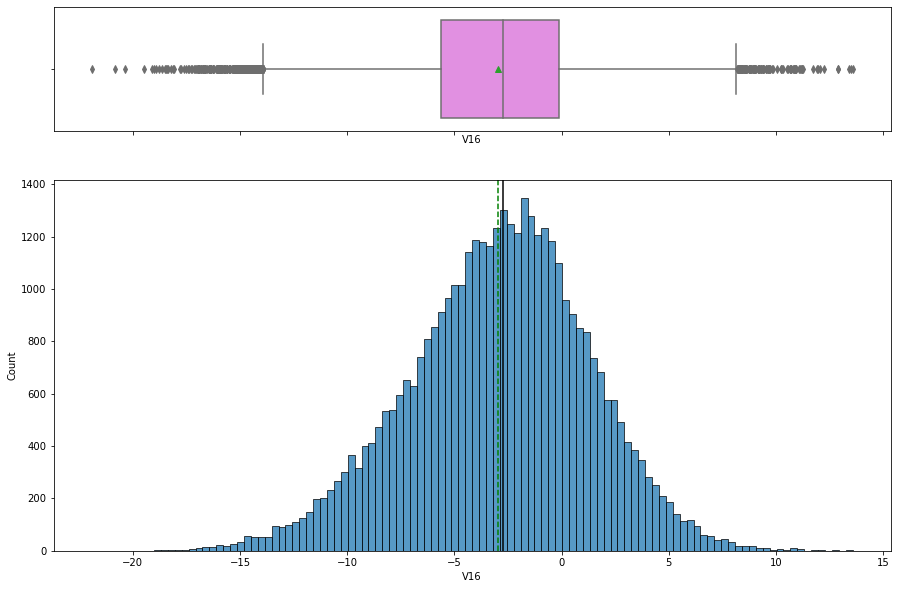

<Figure size 720x360 with 0 Axes>

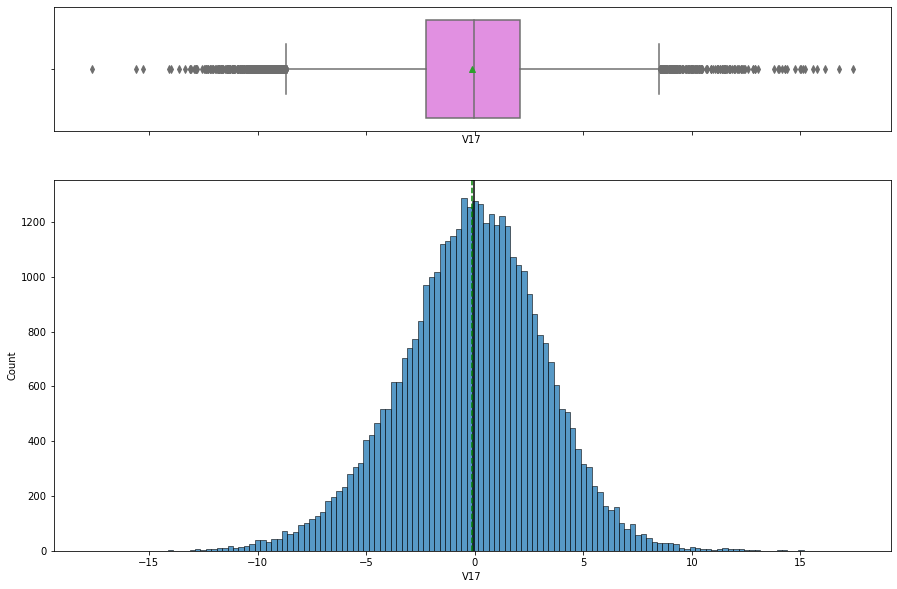

<Figure size 720x360 with 0 Axes>

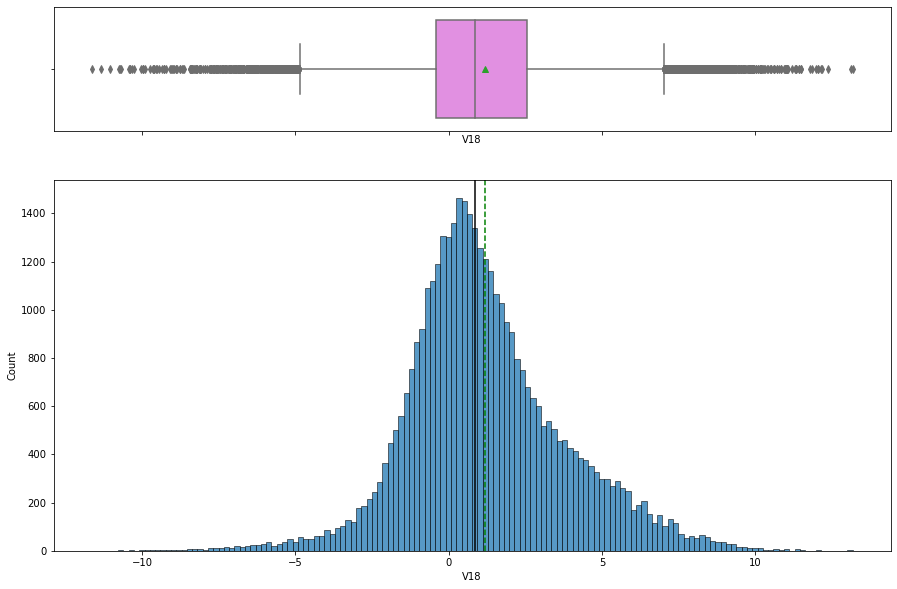

<Figure size 720x360 with 0 Axes>

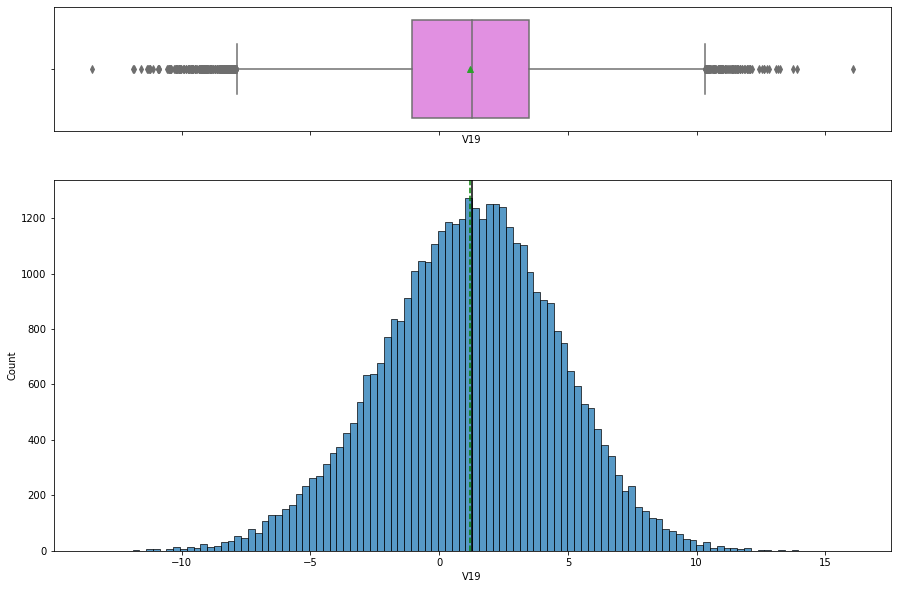

<Figure size 720x360 with 0 Axes>

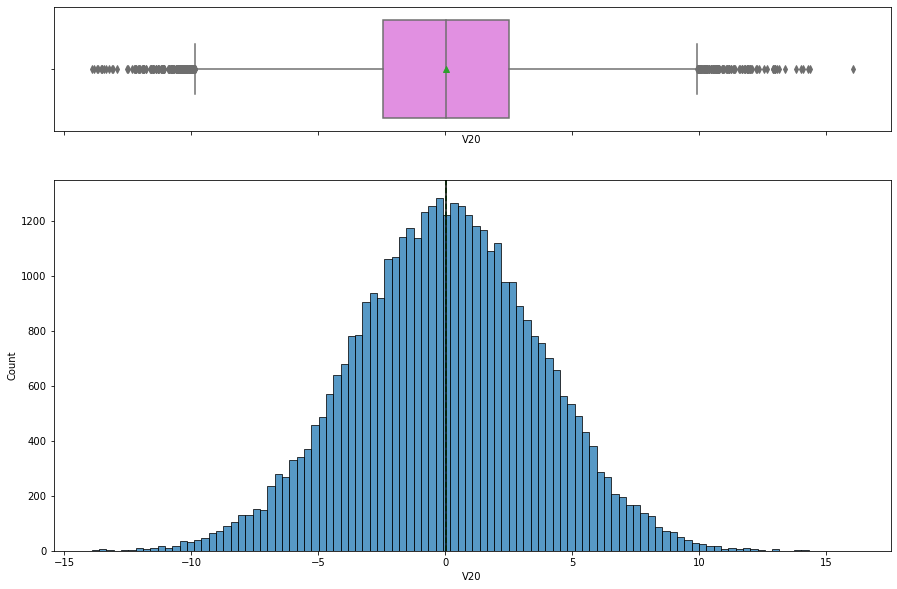

<Figure size 720x360 with 0 Axes>

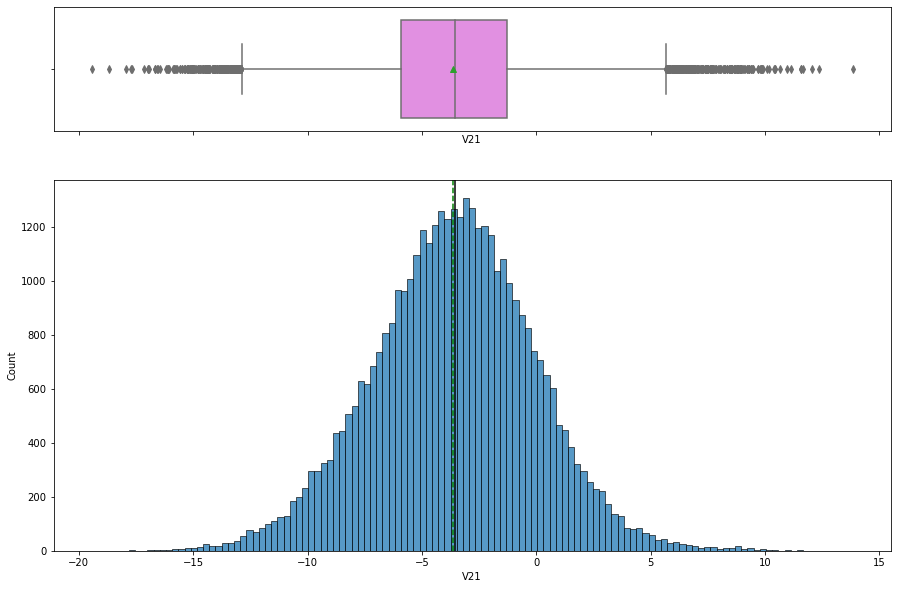

<Figure size 720x360 with 0 Axes>

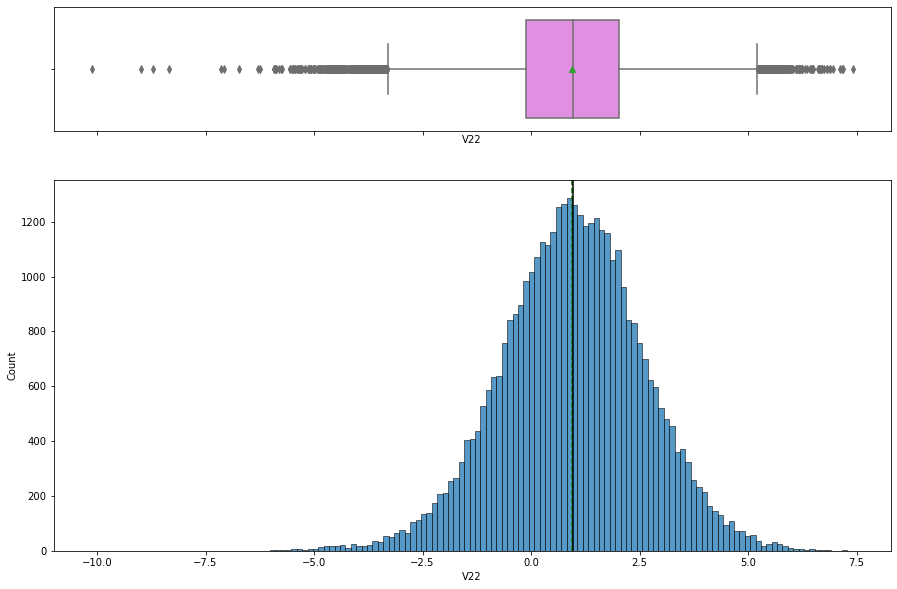

<Figure size 720x360 with 0 Axes>

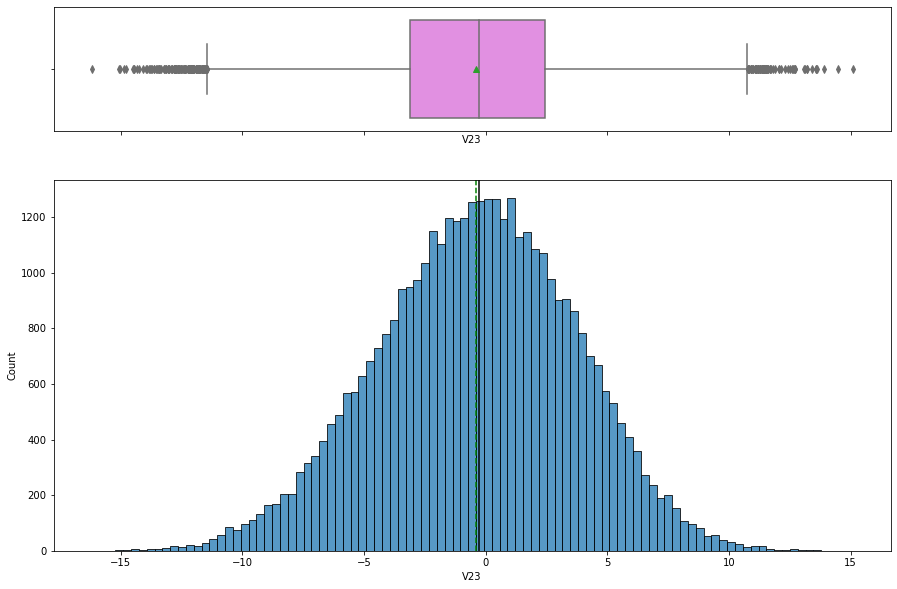

<Figure size 720x360 with 0 Axes>

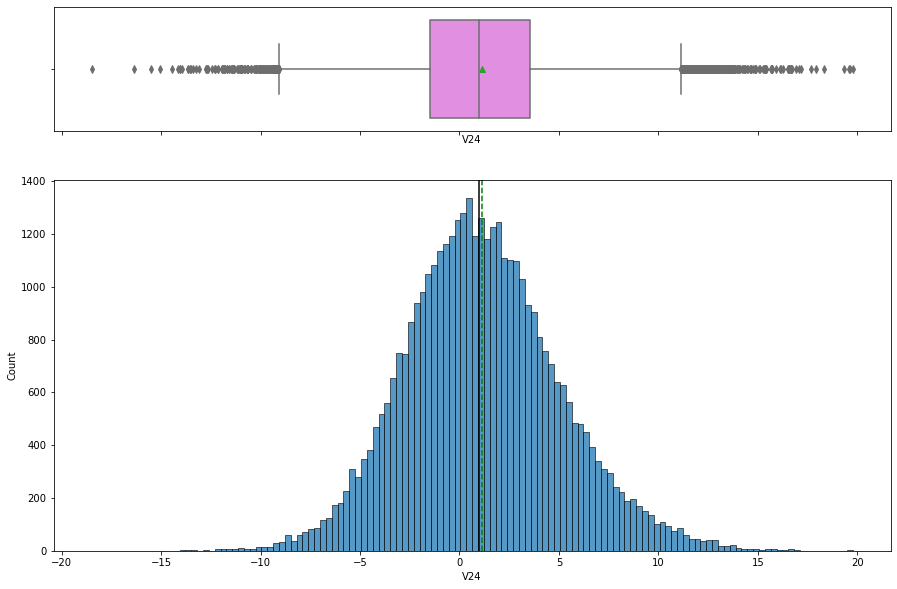

<Figure size 720x360 with 0 Axes>

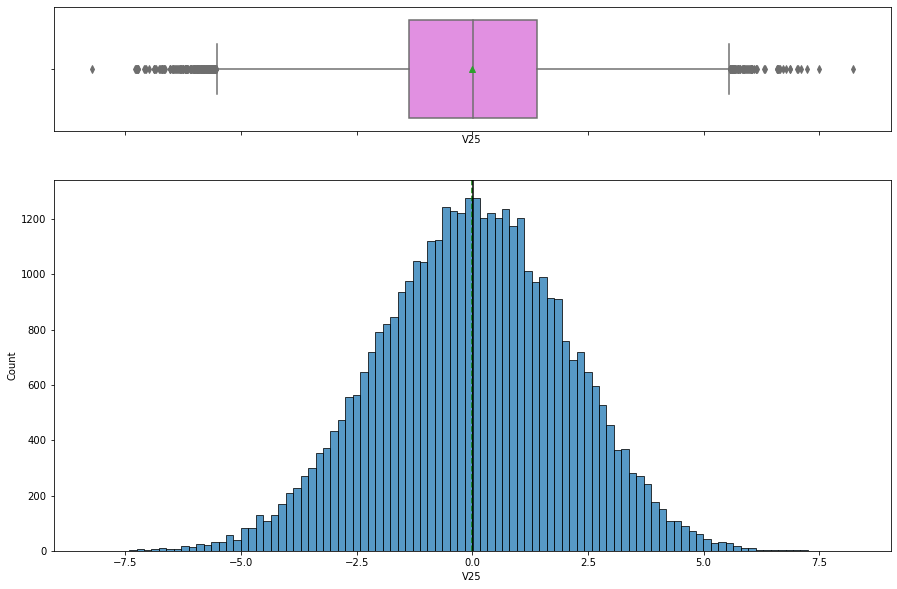

<Figure size 720x360 with 0 Axes>

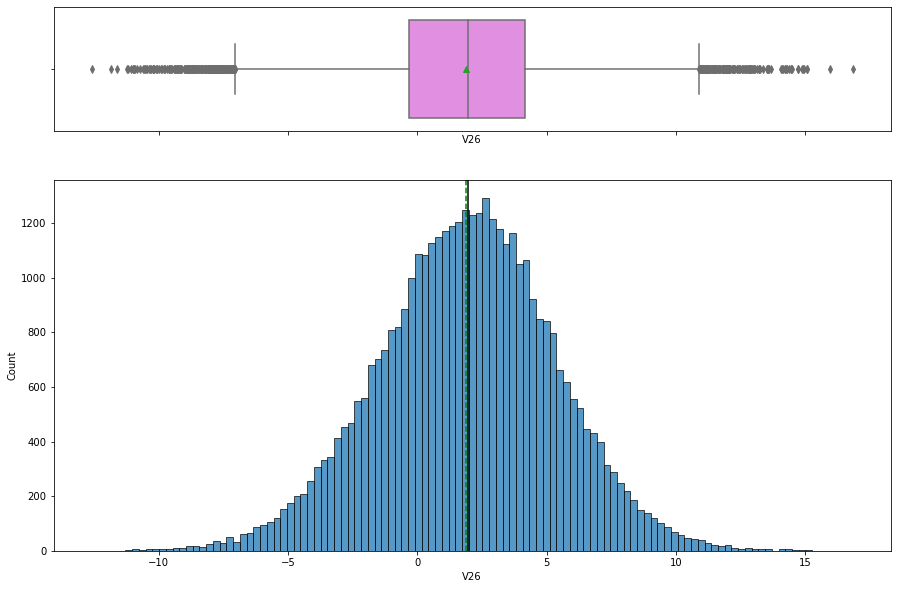

<Figure size 720x360 with 0 Axes>

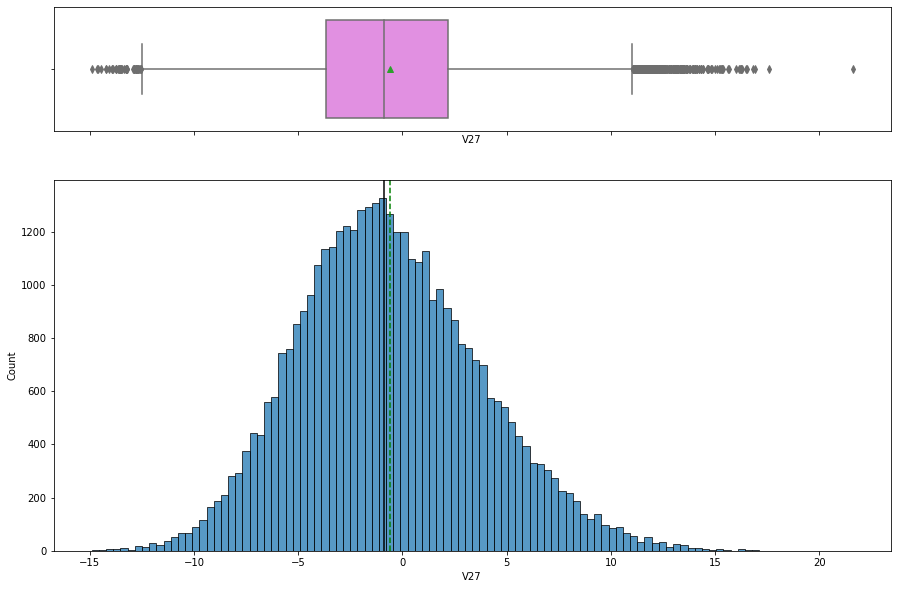

<Figure size 720x360 with 0 Axes>

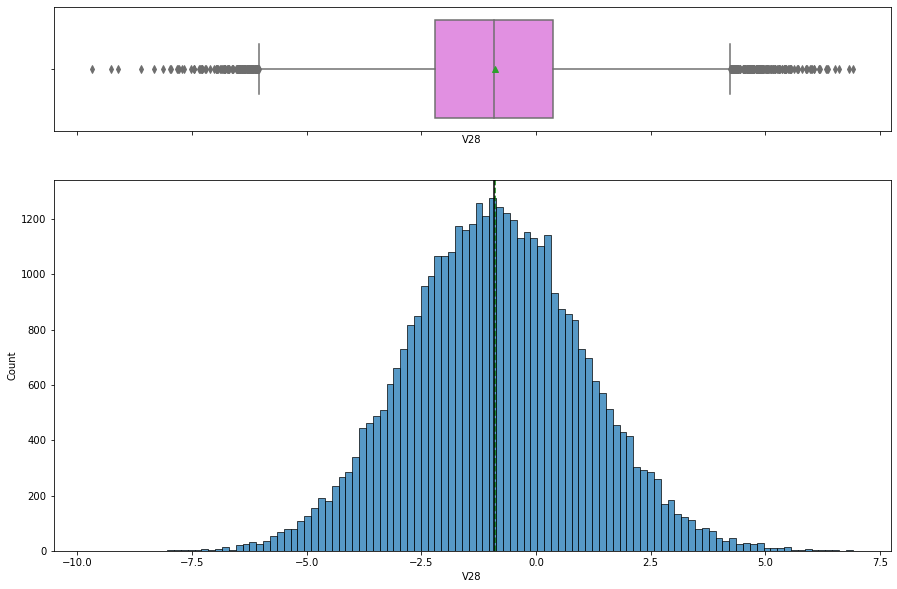

<Figure size 720x360 with 0 Axes>

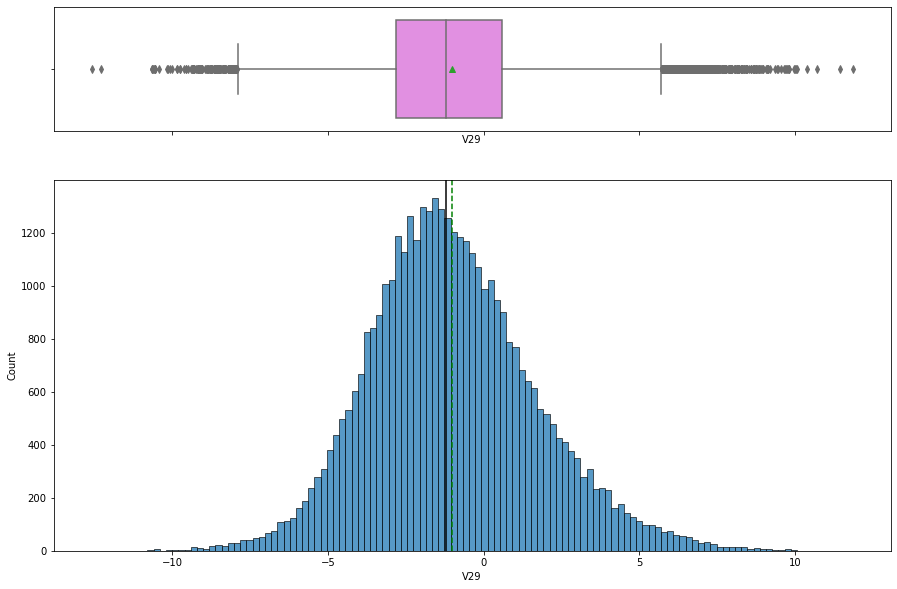

<Figure size 720x360 with 0 Axes>

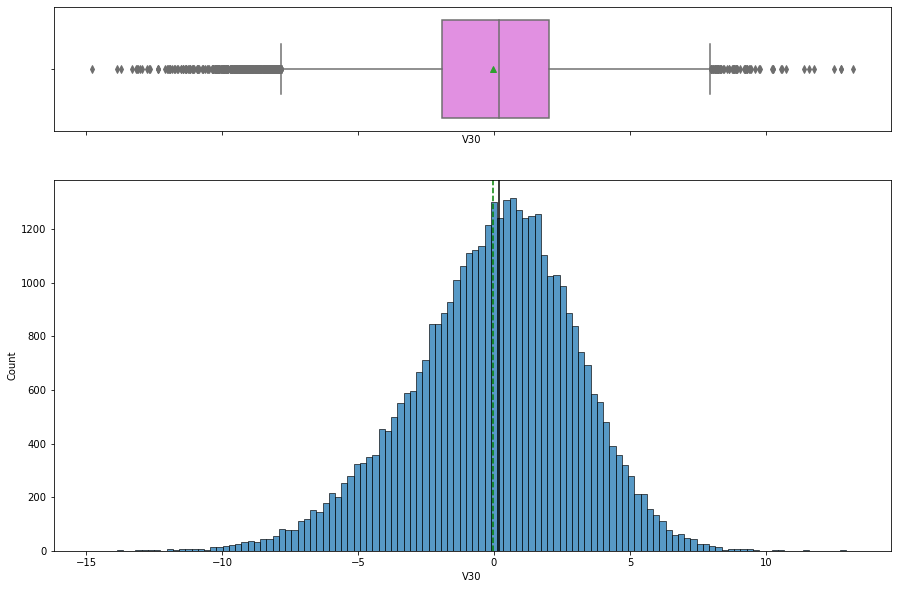

<Figure size 720x360 with 0 Axes>

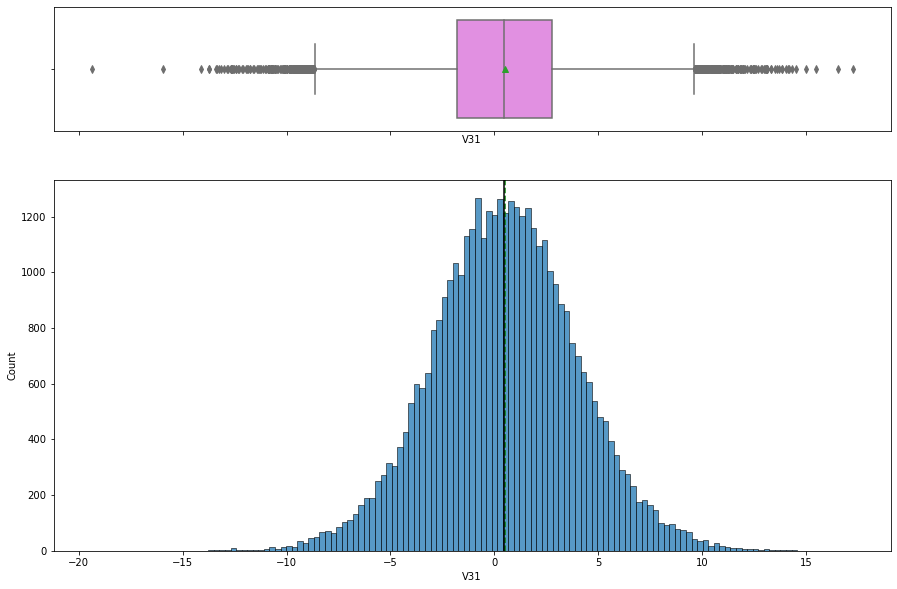

<Figure size 720x360 with 0 Axes>

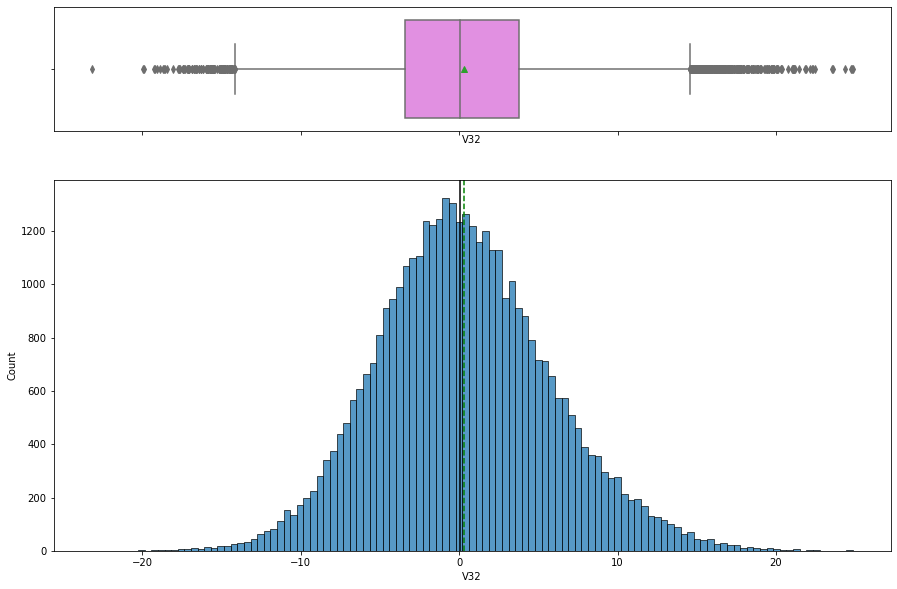

<Figure size 720x360 with 0 Axes>

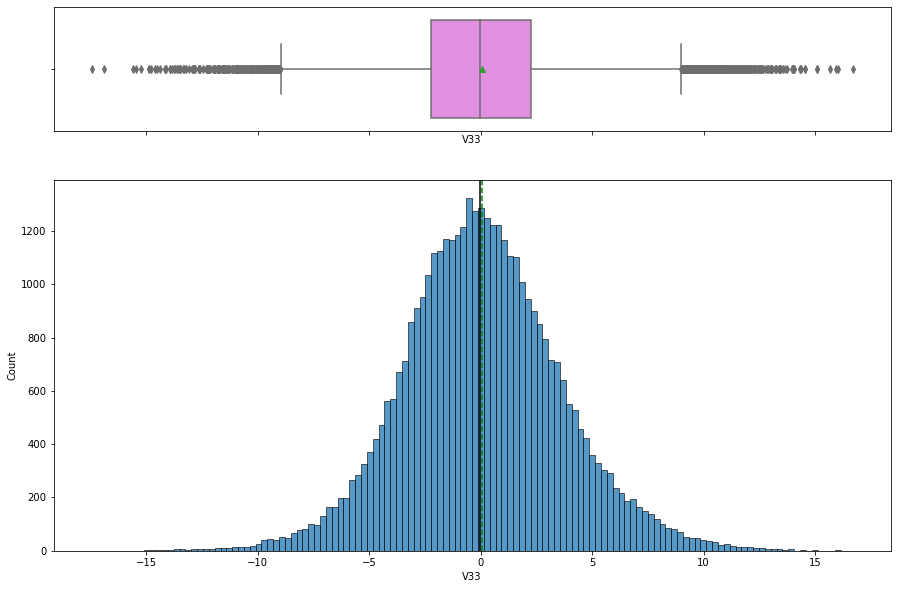

<Figure size 720x360 with 0 Axes>

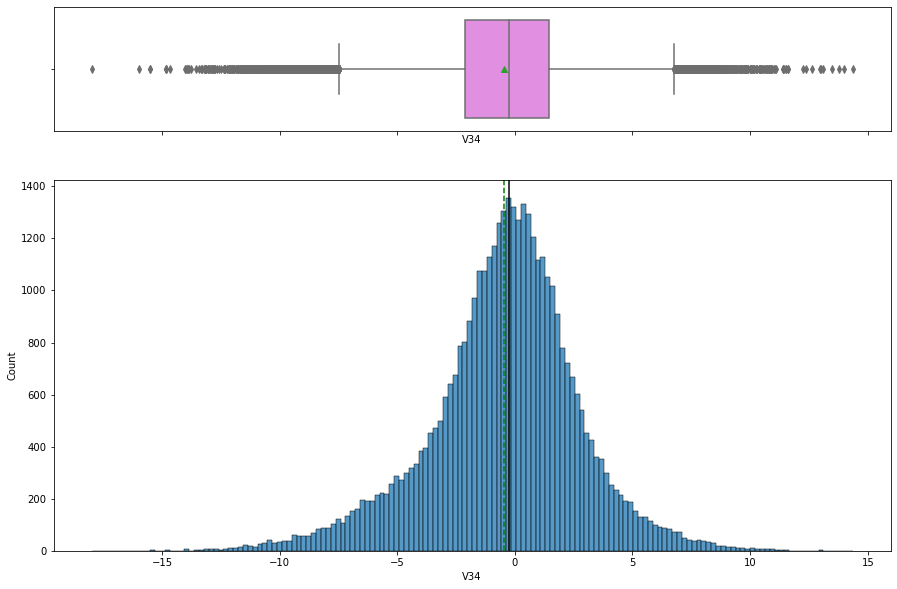

<Figure size 720x360 with 0 Axes>

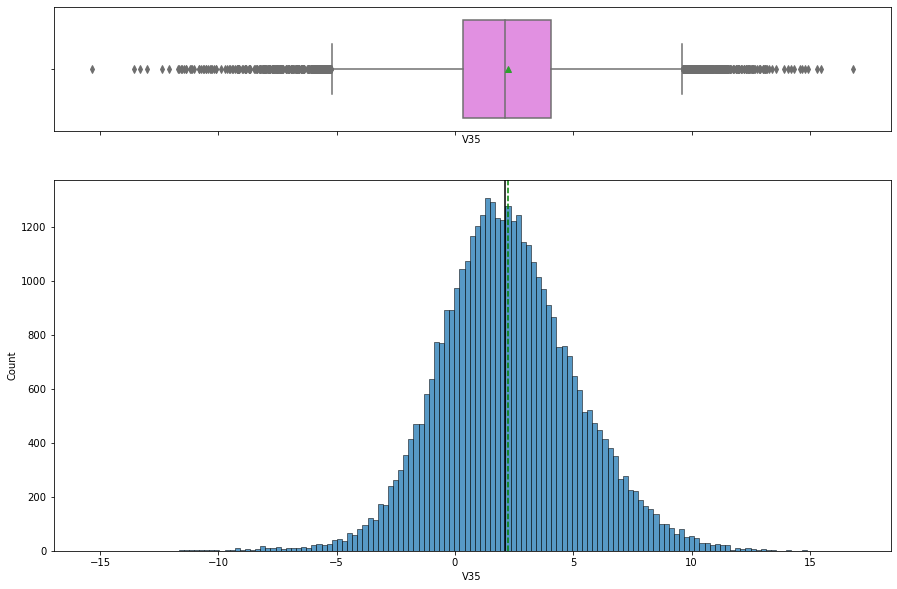

<Figure size 720x360 with 0 Axes>

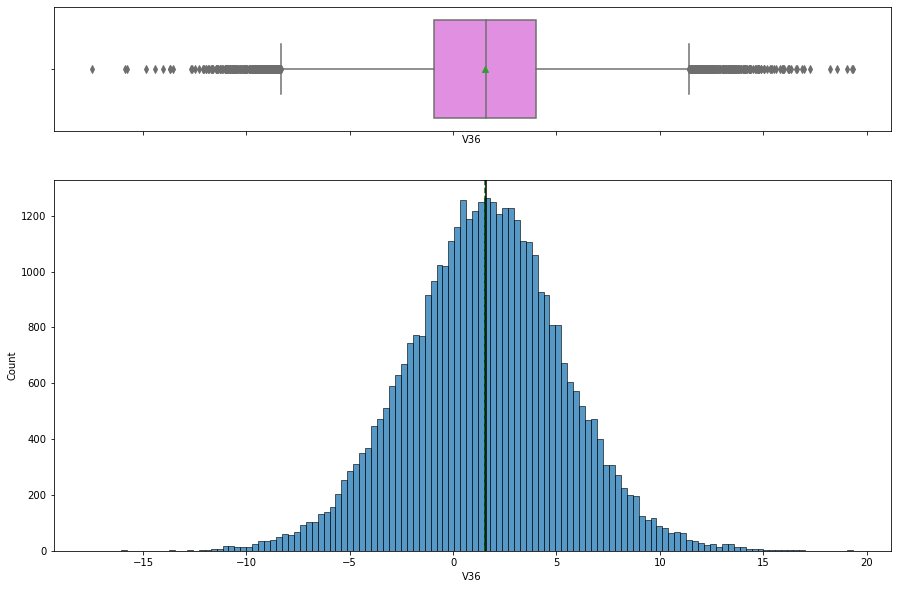

<Figure size 720x360 with 0 Axes>

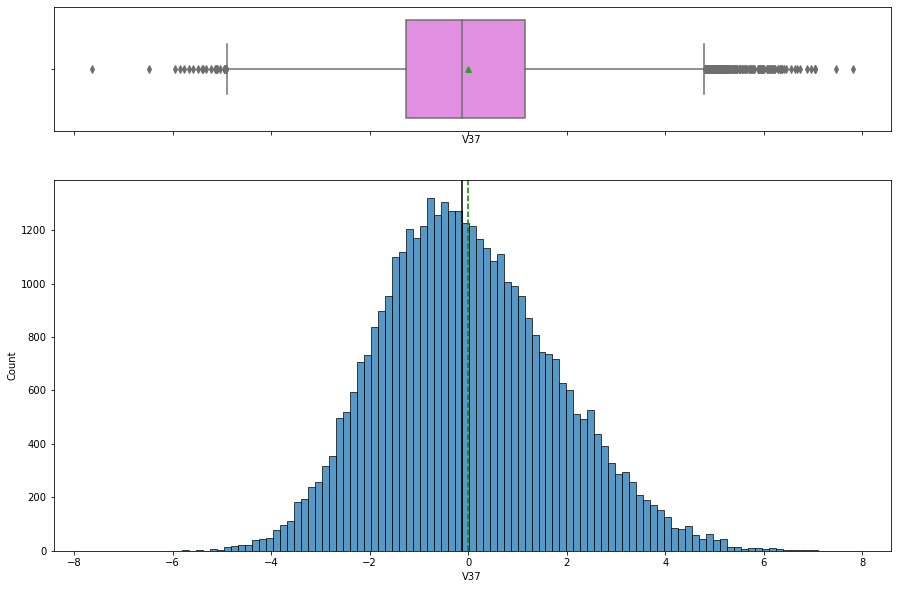

<Figure size 720x360 with 0 Axes>

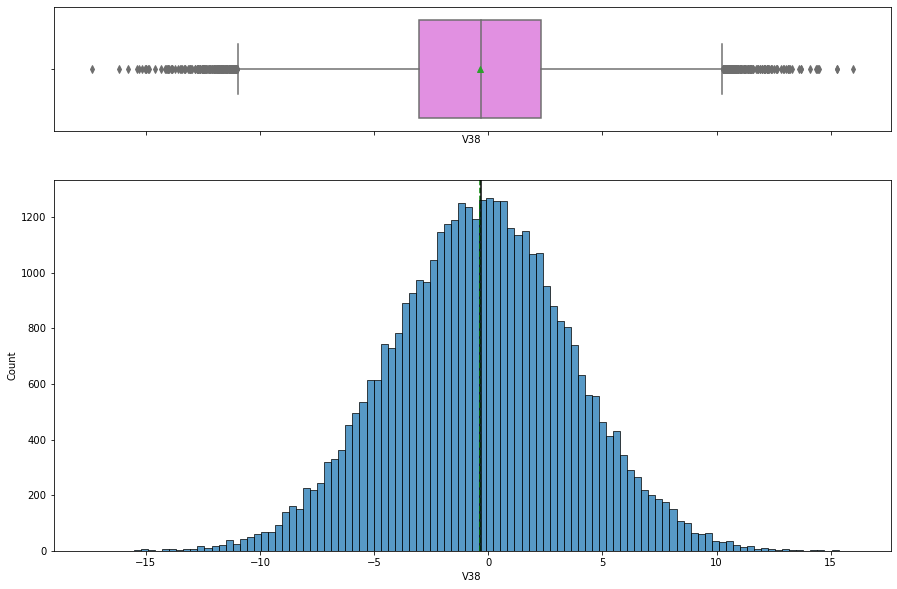

<Figure size 720x360 with 0 Axes>

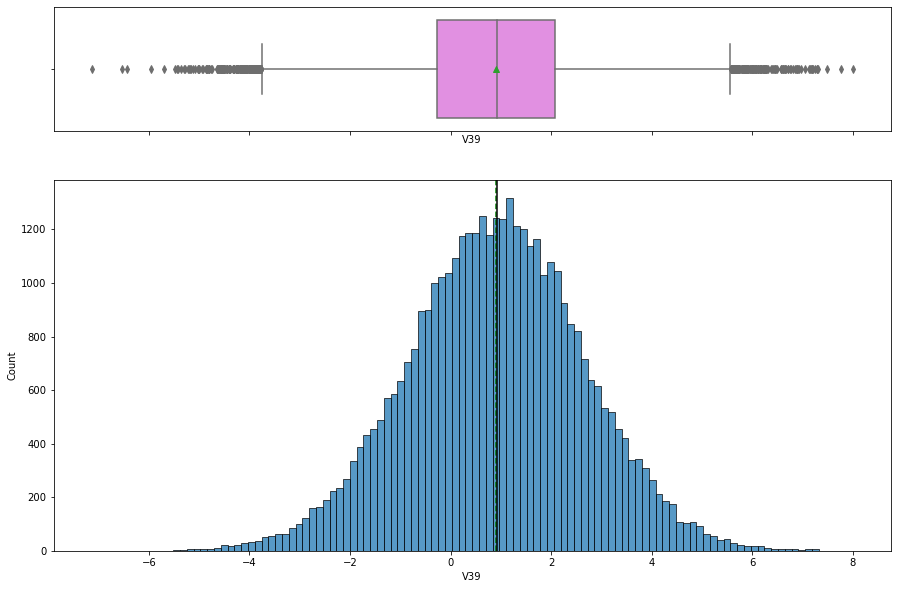

<Figure size 720x360 with 0 Axes>

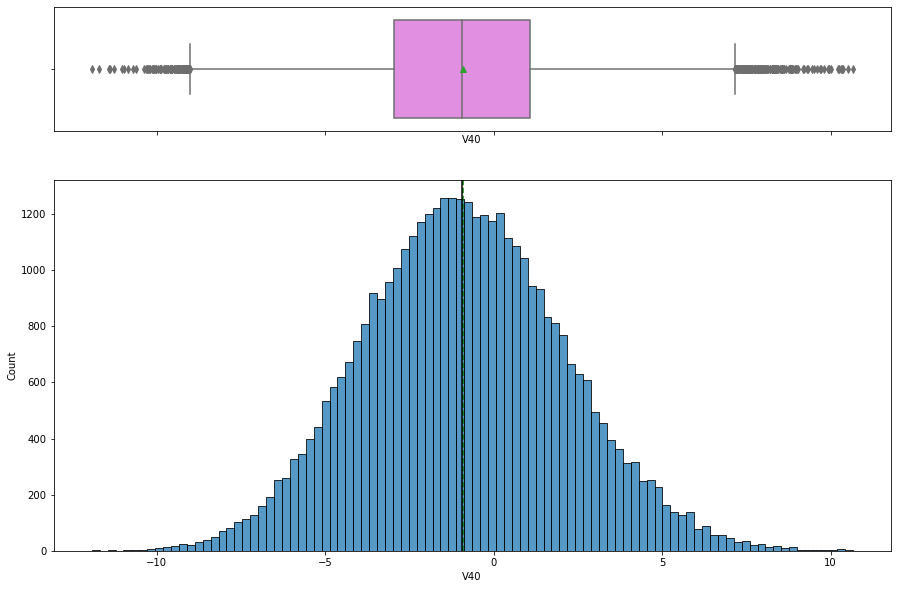

<Figure size 720x360 with 0 Axes>

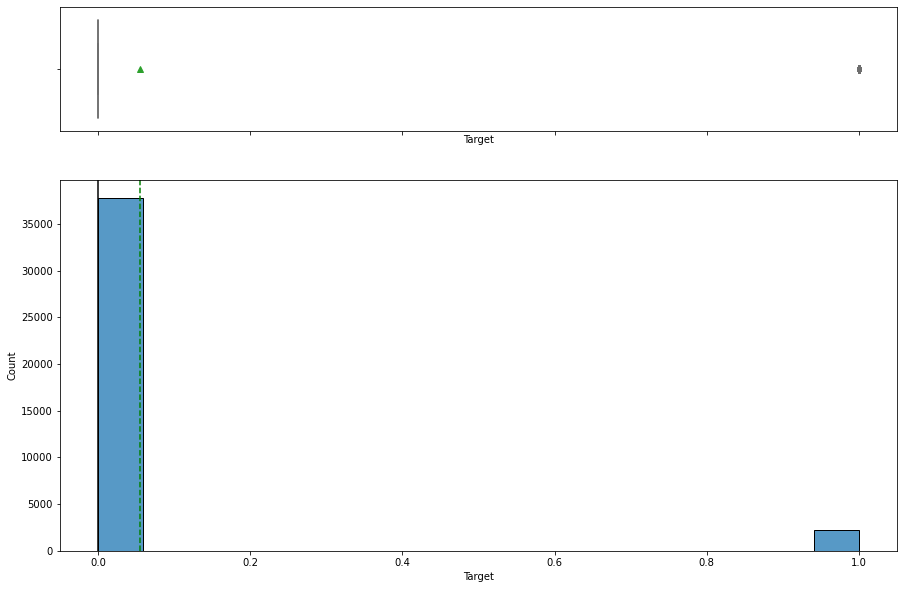

<IPython.core.display.Javascript object>

In [17]:
for column in traindata.columns :
    plt.figure(figsize=(10, 5))
    histogram_boxplot(traindata, column)
    plt.show()

## Data Pre-processing

In [18]:
## Dropping the targeted column from traindata
X = traindata.drop(["Target"], axis=1)
y = traindata["Target"]

<IPython.core.display.Javascript object>

In [19]:
copy_test = testdata.copy()

<IPython.core.display.Javascript object>

In [20]:
## Dropping the targeted column from traindata
X_test = testdata.drop(["Target"], axis=1)
y_test = testdata["Target"]

<IPython.core.display.Javascript object>

In [21]:
y.value_counts(1)


0   0.945
1   0.055
Name: Target, dtype: float64

<IPython.core.display.Javascript object>

In [22]:
y_test.value_counts(1)

0   0.945
1   0.055
Name: Target, dtype: float64

<IPython.core.display.Javascript object>

In [23]:
# Splitting data into training and validation:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
print(X_train.shape, X_val.shape)

(32000, 40) (8000, 40)


<IPython.core.display.Javascript object>

In [24]:
y_val.value_counts(1)

0   0.945
1   0.055
Name: Target, dtype: float64

<IPython.core.display.Javascript object>

### Missing-Value Treatment

* We will use mode to impute missing values in V1 and V2 columns.

In [25]:
# Let's impute the missing values
imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
cols_to_impute = ["V1", "V2"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])

<IPython.core.display.Javascript object>

## Model evaluation criterion

### 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure 
3. Repair cost - True Positives - Predicting failure correctly

### How to reduce the overall cost?
* We need to create a customized metric, that can help to bring down the overall cost.
* The cost associated with any model = TP * 15000 + FP * 5000 + FN * 40000
* And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN) * 15000
* So, we will try to maximize `Minimum cost/Cost associated with model`

**Let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [26]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (TP + FN) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = Min_Cost / Cost  # ratio of minimum possible maintenance cost and maintenance cost by model

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [34]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    print("Confusion Matrix for Model:", name)
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    

<IPython.core.display.Javascript object>

## Model Building with Original data

In [29]:
## Running the models for train data in the loop.

model_train = []  # Empty list to store all the model_train

# Appending model_train into the list
model_train.append(("Logistic Regression", LogisticRegression(random_state=1)))
model_train.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
model_train.append(("Random forest", RandomForestClassifier(random_state=1)))
model_train.append(("Bagging", BaggingClassifier(random_state=1)))
model_train.append(("GBM", GradientBoostingClassifier(random_state=1)))
model_train.append(("Adaboost", AdaBoostClassifier(random_state=1)))

print("\n" "Model Training Performance on on Train data:" "\n")

for name, model in model_train:
    model.fit(X_train, y_train)
    df_perf_train = model_performance_classification_sklearn(model, X_train, y_train)
    print(name, df_perf_train)
    
print("\n" "Model Training Performance on on Validation data:" "\n")

for name, model in model_train:
    df_perf_val = model_performance_classification_sklearn(model, X_val, y_val)
    print(name, df_perf_val)


Model Training Performance on on Train data:

Logistic Regression    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.967   0.479      0.849 0.613                  0.527
DecisionTree    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     1.000   1.000      1.000 1.000                  1.000
Random forest    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     1.000   0.998      0.999 0.999                  0.997
Bagging    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.998   0.957      0.998 0.977                  0.932
GBM    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.987   0.781      0.978 0.868                  0.730
Adaboost    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.975   0.632      0.879 0.735                  0.609

Model Training Performance on on Validation data:

Logistic Regression    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.967   0.483      0.854 0.

<IPython.core.display.Javascript object>

Confusion Matrix for Model: Logistic Regression
Confusion Matrix for Model: DecisionTree
Confusion Matrix for Model: Random forest
Confusion Matrix for Model: Bagging
Confusion Matrix for Model: GBM
Confusion Matrix for Model: Adaboost


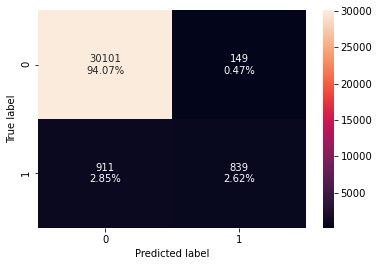

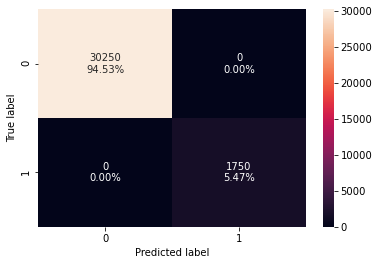

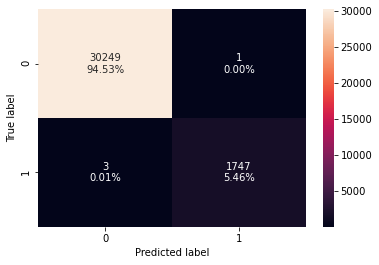

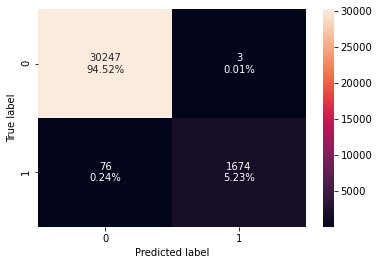

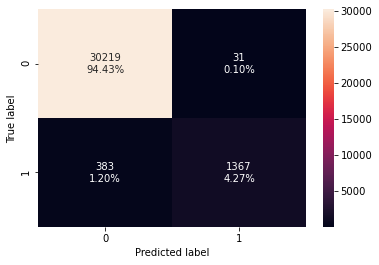

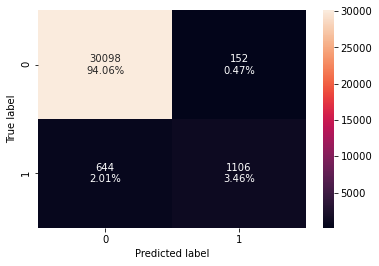

<IPython.core.display.Javascript object>

In [40]:
## Confusion matrix on train data models
for name, model in model_train:
    confusion_matrix_sklearn(model,X_train,y_train)
    
    
        

Confusion Matrix for Model: Logistic
Confusion Matrix for Model: dtree
Confusion Matrix for Model: Random forest
Confusion Matrix for Model: Bagging
Confusion Matrix for Model: GBM
Confusion Matrix for Model: Adaboost


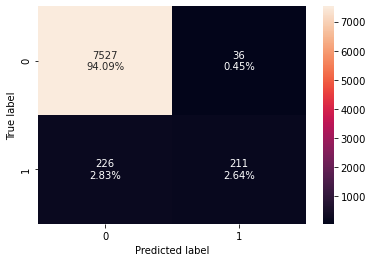

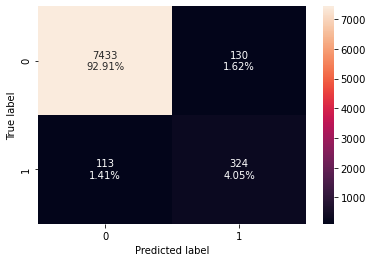

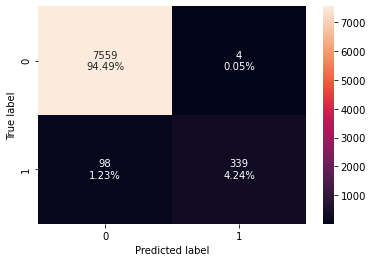

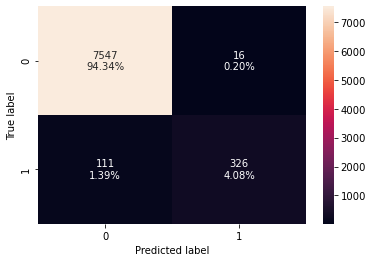

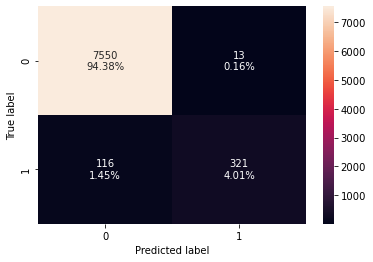

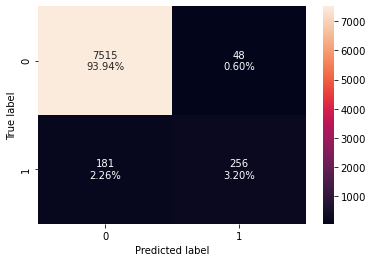

<IPython.core.display.Javascript object>

In [29]:
## Confusion matrix on Validation data models
for name, model in model_train:
    confusion_matrix_sklearn(model,X_val,y_val)

## Model Building with Oversampled data

### SMOTE to Over Sampling of smaller class

In [30]:
### Over Sampling of Train data using SMOTE. 
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())


print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))



print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))


Before OverSampling, counts of label '1': 1750
Before OverSampling, counts of label '0': 30250 

After OverSampling, counts of label '1': 30250
After OverSampling, counts of label '0': 30250 

After OverSampling, the shape of train_X: (60500, 40)
After OverSampling, the shape of train_y: (60500,) 



<IPython.core.display.Javascript object>

In [31]:
## Running the models for train data in the loop after over sampling.

models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("Logistic", LogisticRegression(random_state=1)))
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))

print("\n" "Model Training Performance on Oversampled Train data :" "\n")
for name, model in models_over:
    model.fit(X_train_res, y_train_res)
    df_perf_over_train = model_performance_classification_sklearn(model,X_train_res,y_train_res)
    print(name, df_perf_over_train)
    
print("\n" "Model Training Performance on Oversampled Validation data :" "\n")    
    
for name, model in models_over:
    df_perf_over_val = model_performance_classification_sklearn(model,X_val,y_val)
    print(name, df_perf_over_val)
    
    


Model Training Performance on Oversampled Train data :

Logistic    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.873   0.875      0.872 0.874                  0.799
dtree    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     1.000   1.000      1.000 1.000                  1.000
Random forest    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     1.000   1.000      1.000 1.000                  1.000
Bagging    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.999   0.998      1.000 0.999                  0.997
GBM    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.944   0.918      0.969 0.943                  0.872
Adaboost    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.906   0.897      0.912 0.905                  0.833

Model Training Performance on Oversampled Validation data :

Logistic    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.871   0.840      0.276 0.415      

<IPython.core.display.Javascript object>

Confusion Matrix for Model: Logistic
Confusion Matrix for Model: dtree
Confusion Matrix for Model: Random forest
Confusion Matrix for Model: Bagging
Confusion Matrix for Model: GBM
Confusion Matrix for Model: Adaboost


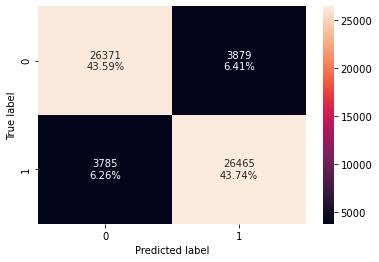

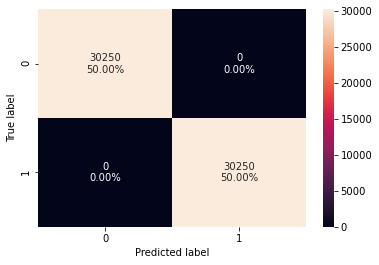

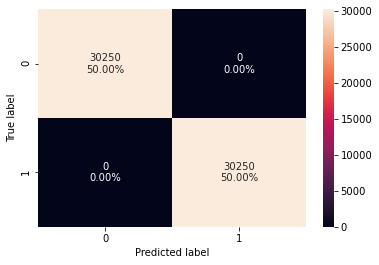

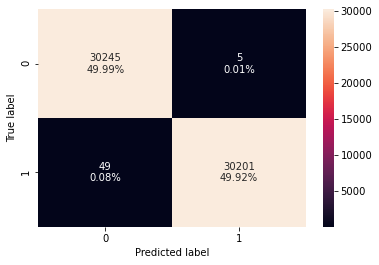

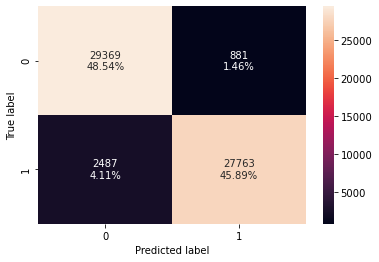

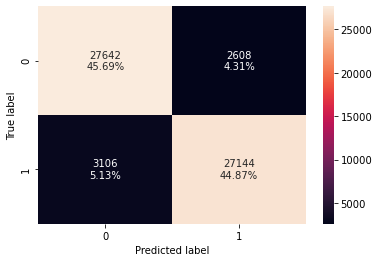

<IPython.core.display.Javascript object>

In [32]:
## Confusion matrix on train data in the loop after over sampling.
for name, model in models_over:
    confusion_matrix_sklearn(model,X_train_res,y_train_res)

Confusion Matrix for Model: Logistic
Confusion Matrix for Model: dtree
Confusion Matrix for Model: Random forest
Confusion Matrix for Model: Bagging
Confusion Matrix for Model: GBM
Confusion Matrix for Model: Adaboost


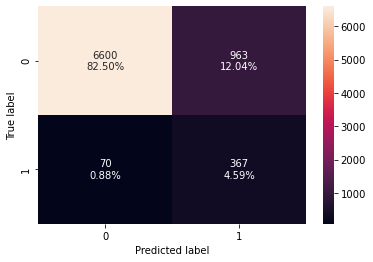

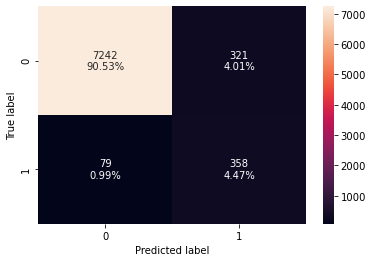

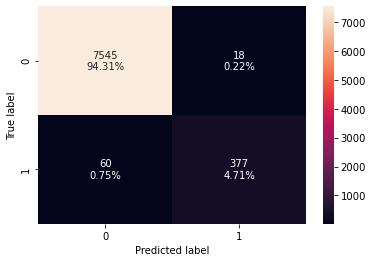

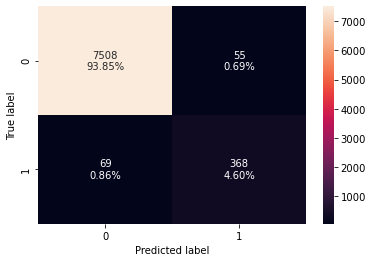

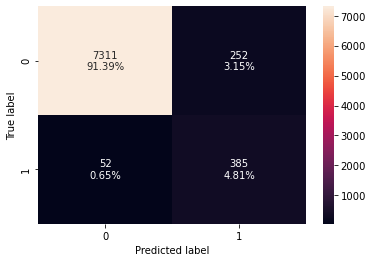

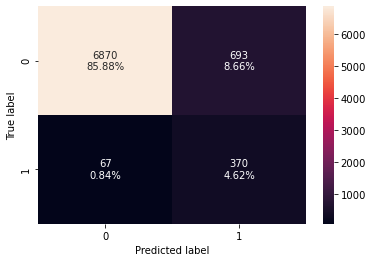

<IPython.core.display.Javascript object>

In [34]:
## Confusion matrix on Validation data in the loop after over sampling.
for name, model in models_over:
    confusion_matrix_sklearn(model,X_val,y_val)

## Model Building with Undersampled data

###  RandomUnderSampler to under sampliung of higher class

In [35]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


<IPython.core.display.Javascript object>

In [36]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))


Before Under Sampling, counts of label 'Yes': 1750
Before Under Sampling, counts of label 'No': 30250 

After Under Sampling, counts of label 'Yes': 1750
After Under Sampling, counts of label 'No': 1750 

After Under Sampling, the shape of train_X: (3500, 40)
After Under Sampling, the shape of train_y: (3500,) 



<IPython.core.display.Javascript object>

In [37]:
## Running the models for train data in the loop after Under sampling.

models_under = []  # Empty list to store all the models

# Appending models into the list
models_under.append(("Logistic", LogisticRegression(random_state=1)))
models_under.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_under.append(("Random forest", RandomForestClassifier(random_state=1)))
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))

print("\n" "Model Training Performance on Under Sampled Train data :" "\n")

for name, model in models_under:
    model.fit(X_train_un, y_train_un)
    df_perf_under_train = model_performance_classification_sklearn(model,X_train_un,y_train_un)
    print(name,df_perf_under_train)
    
print("\n" "Model Training Performance on Under Sampled Validation data :" "\n")    
    
for name, model in models_over:
    df_perf_over_val = model_performance_classification_sklearn(model,X_val,y_val)
    print(name, df_perf_over_val)




Model Training Performance on Under Sampled Train data :

Logistic    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.862   0.856      0.867 0.861                  0.779
dtree    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     1.000   1.000      1.000 1.000                  1.000
Random forest    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     1.000   1.000      1.000 1.000                  1.000
Bagging    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.989   0.979      0.999 0.989                  0.966
GBM    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.953   0.923      0.982 0.951                  0.882
Adaboost    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.903   0.887      0.917 0.902                  0.823

Model Training Performance on Under Sampled Validation data :

Logistic    Accuracy  Recall  Precision    F1  Minimum_Vs_Model_cost
0     0.871   0.840      0.276 0.415  

<IPython.core.display.Javascript object>

Confusion Matrix for Model: Logistic
Confusion Matrix for Model: dtree
Confusion Matrix for Model: Random forest
Confusion Matrix for Model: Bagging
Confusion Matrix for Model: GBM
Confusion Matrix for Model: Adaboost


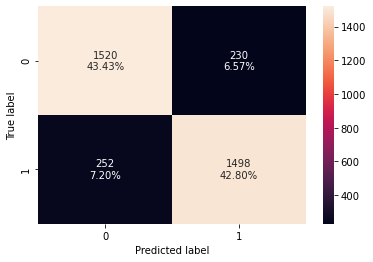

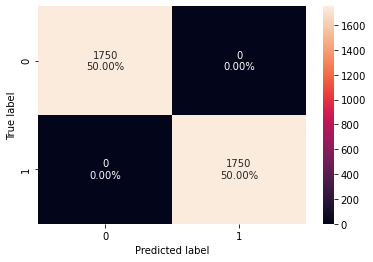

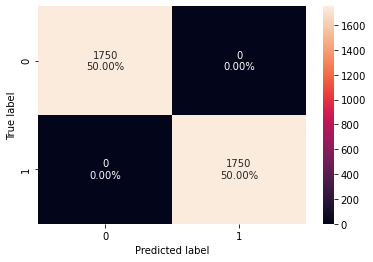

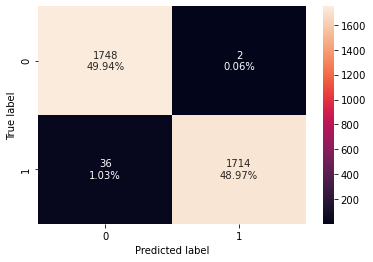

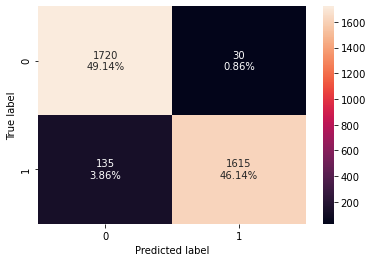

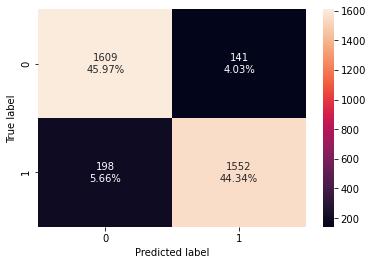

<IPython.core.display.Javascript object>

In [38]:
## Confusion matrix on train data in the loop after Under  sampling.
for name, model in models_under:
    confusion_matrix_sklearn(model,X_train_un,y_train_un)

Confusion Matrix for Model: Logistic
Confusion Matrix for Model: dtree
Confusion Matrix for Model: Random forest
Confusion Matrix for Model: Bagging
Confusion Matrix for Model: GBM
Confusion Matrix for Model: Adaboost


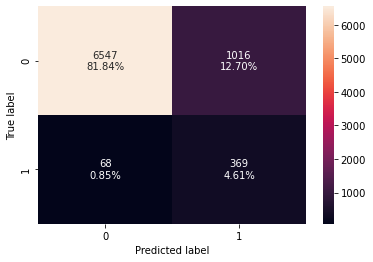

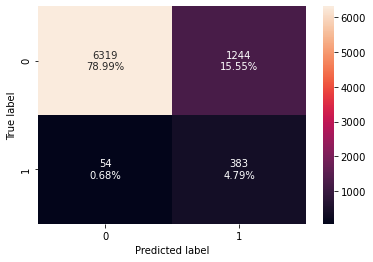

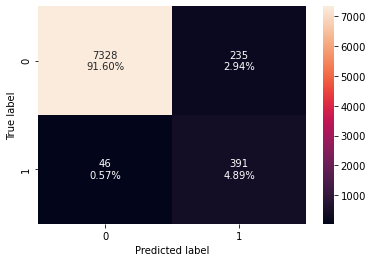

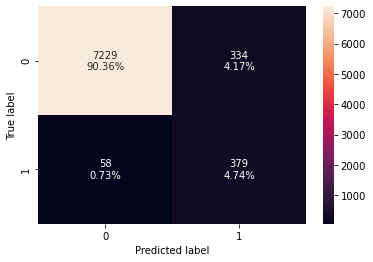

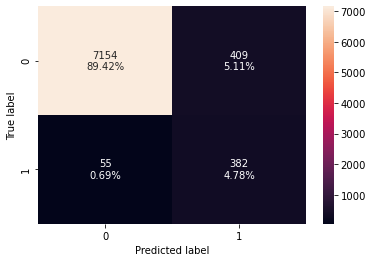

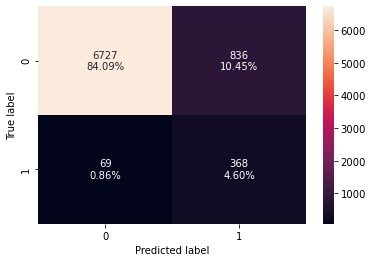

<IPython.core.display.Javascript object>

In [39]:
## Confusion matrix on Validation  data in the loop after Under  sampling.
for name, model in models_under:
    confusion_matrix_sklearn(model,X_val,y_val)

## Comparing all models


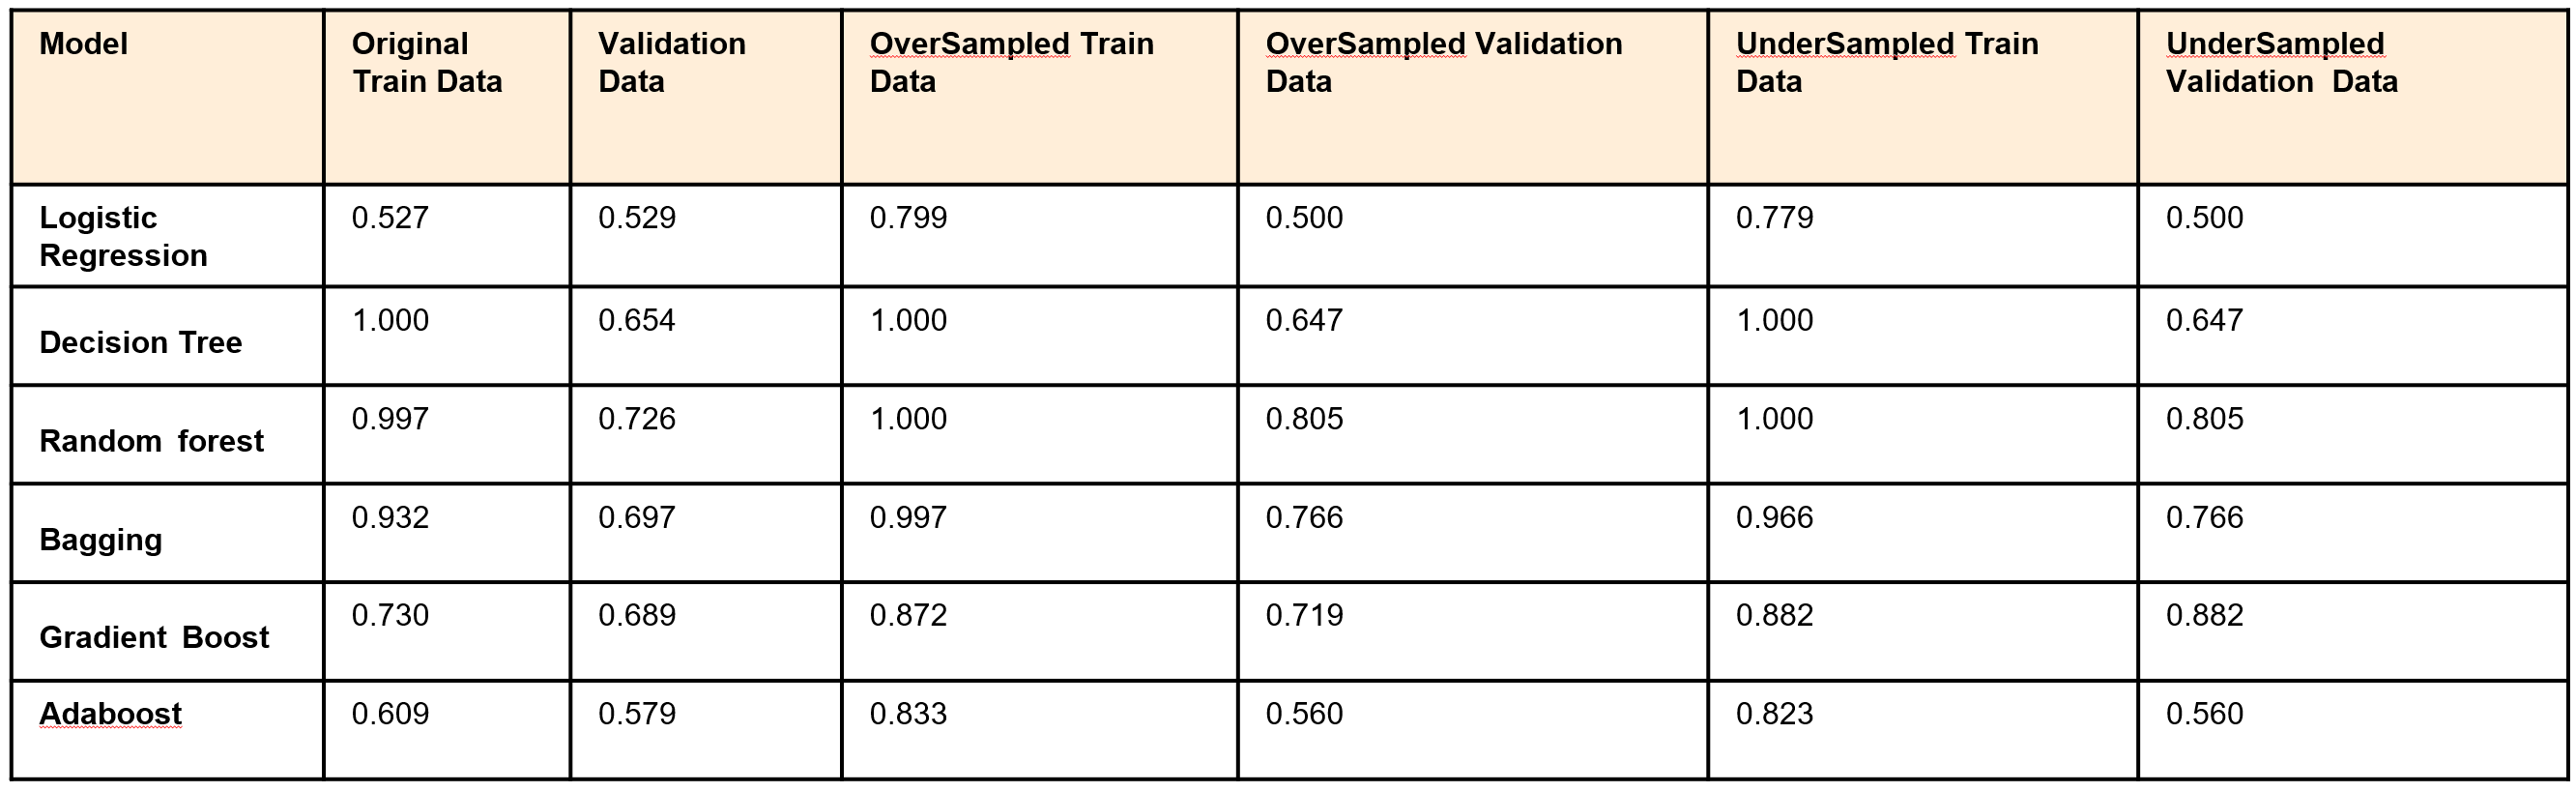


## Model Selection

#### We selected our models based upon the performance of Minimum_Vs_Model_cost values, Hence our objective is to maximize the `maximize(minimum possible maintenance cost/maintenance cost)`. 



## Our top 3 models for evaluations are 
* Random Forest
* Bagging 
* Gradient Boost


## **Defining scorer to be used for hyperparameter tuning**

- Every prediction of a classification model will be either a TP, FP, FN or TN.
- Till now at most of the places we wanted to reduce False negatives and hence we tried to maximize "Recall".
- To maximize Recall, we used Recall as a **scorer** in hyperparameter tuning.
- Here, we not only want to minimize false negatives but also false positives and we are also given the costs associated with each type of prediction.
- So, overall we want to reduce the maintenance cost which is: `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
- In simple language, we can say that we are assigning different weightage to the different types of predictions.
- Do we have any such metric which can help us minimize the maintenance cost? i.e., help us reduce FP and FN as per the weightage - We don't have any such inbuilt metric.
- In sklearn, we can define **custom scorers** also as per our need.
- For this classification problem, we need to reduce the maintenance cost, which can be reiterated as:
  - Minimize (maintenance cost)
  - Maximize (1/maintenance cost)
  - Maximize (minimum possible maintenance cost/maintenance cost)
- Eventually, all 3 metrics will do the same work in the backend and the only difference will be in the scale of the values of the metric.
- The metric provided in the next cell is to `maximize(minimum possible maintenance cost/maintenance cost)`
- You can modify the metric as per convenience and use it further to tune the models.

In [40]:
# defining metric to be used for optimization and with cross-validation
def Minimum_Vs_Model_cost(y_train, y_pred):
    """
    We want the model to optimize the maintenance cost and reduce it to the lowest possible value.
    The lowest possible maintenance cost will be achieved when each sample is predicted correctly.

    In such a scenario, the maintenance cost will be the total number of failures times the maintenance cost of replacing one generator,
    which is given by (TP + FN) * 40 (i.e., the actual positives*40).
    For any other scenario,
    the maintenance cost associated with the model will be given by (TP * 15 + FP * 5 + FN * 40).

    We will use the ratio of these two maintenance costs as the cost function for our model.
    The greater the ratio, the lower the associated maintenance cost and the better the model.
    """
    TP = confusion_matrix(y_train, y_pred)[1, 1]
    FP = confusion_matrix(y_train, y_pred)[0, 1]
    FN = confusion_matrix(y_train, y_pred)[1, 0]
    return ((TP + FN) * 15) / (TP * 15 + FP * 5 + FN * 40)


# A value of .80 here, will represent that the minimum maintenance cost is 80% of the maintenance cost associated with the model.
# Since minimum maintenance cost is constant for any data, when minimum cost will become 100% of maintenance cost associated with the model
# Model will have give the least possible maintenance cost.


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Higher the values, the lower the maintenance cost

<IPython.core.display.Javascript object>

## HyperparameterTuning for our selected model.

- **Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

#### For XGBoost:
param_grid={'n_estimators':np.arange(150,300,50),'scale_pos_weight':[5,10],
            'learning_rate':[0.1,0.2], 'gamma':[0,3,5],
            'subsample':[0.8,0.9]}

#### For Gradient Boosting:
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]}


#### For Adaboost:
param_grid = {
    "n_estimators": np.arange(10, 110, 20),
    "learning_rate": [ 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1)]}

#### For logistic Regression:
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#### For Bagging Classifier:
param_grid = {
              'max_samples': [0.8,0.9], 
              'max_features': [0.8,0.9],
              'n_estimators' : [40,50]}

#### For Random Forest:
param_grid = {
    "n_estimators": [150,250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ['sqrt','log2'],
    "max_samples": np.arange(0.2, 0.6, 0.1)}

#### For Decision Trees:
param_grid = {'max_depth': np.arange(2,20), 
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001]
             }

## Hyperparameter tuning for Random Forest using GridSearch.

In [41]:
%%time 

# defining model
model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV

param_grid = { "n_estimators": [150,250], "min_samples_leaf": np.arange(1, 3), "max_features": ['sqrt','log2'], "max_samples": np.arange(0.2, 0.6, 0.1)}



# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train_res, y_train_res)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)


Best Parameters:{'max_features': 'log2', 'max_samples': 0.5000000000000001, 'min_samples_leaf': 1, 'n_estimators': 250} 
Score: 0.940985516282146
Wall time: 4min 51s


<IPython.core.display.Javascript object>

In [42]:
# building model with best parameters
rwind_tuned1 = RandomForestClassifier(
    n_estimators=250,
    max_features="sqrt",
    random_state=1,
    max_samples=0.5000000000000001,
    min_samples_leaf=1,
)

# Fit the model on training data
rwind_tuned1.fit(X_train_res, y_train_res)


RandomForestClassifier(max_features='sqrt', max_samples=0.5000000000000001,
                       n_estimators=250, random_state=1)

<IPython.core.display.Javascript object>

In [43]:
# Calculating different metrics on training set
rwind_tuned1_train = model_performance_classification_sklearn(
    rwind_tuned1, X_train_res, y_train_res
)
print("Training performance:")
rwind_tuned1_train


Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.999,0.998,1.000,0.999,0.997


<IPython.core.display.Javascript object>

In [44]:
# Calculating different metrics on validation set
rwind_tuned1_val = model_performance_classification_sklearn(rwind_tuned1, X_val, y_val)
print("Validation performance:")
rwind_tuned1_val


Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.990,0.867,0.950,0.907,0.809


<IPython.core.display.Javascript object>

## Hyperparameter tuning for Bagging using GridSearch.

In [45]:
%%time 

# defining model
model = BaggingClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV

param_grid = { 'max_samples': [0.8,0.9], 'max_features': [0.8,0.9], 'n_estimators' : [40,50]}



# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train_res, y_train_res)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)


Best Parameters:{'max_features': 0.8, 'max_samples': 0.9, 'n_estimators': 50} 
Score: 0.9500048462059554
Wall time: 4min 39s


<IPython.core.display.Javascript object>

In [46]:
# building model with best parameters
bagging_tuned1 = BaggingClassifier(
    n_estimators=50,
    max_features=0.8,
    random_state=1,
    max_samples=0.9
    
)

# Fit the model on training data
bagging_tuned1.fit(X_train_res, y_train_res)


BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=50,
                  random_state=1)

<IPython.core.display.Javascript object>

In [47]:
# Calculating different metrics on training set
bagging_tuned1_train = model_performance_classification_sklearn(
    bagging_tuned1, X_train_res, y_train_res
)
print("Training performance:")
bagging_tuned1_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,1.000,1.000,1.000


<IPython.core.display.Javascript object>

In [48]:
# Calculating different metrics on validation set
bagging_tuned1_val = model_performance_classification_sklearn(bagging_tuned1, X_val, y_val)
print("Validation performance:")
bagging_tuned1_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.988,0.867,0.909,0.888,0.800


<IPython.core.display.Javascript object>

## Hyperparameter tuning for GradientBoostClassifier using GridSearch.

In [49]:
%%time 

# defining model
model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV

param_grid = { "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)], "n_estimators": np.arange(75,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}



# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train_res, y_train_res)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'init': DecisionTreeClassifier(random_state=1), 'learning_rate': 0.2, 'max_features': 0.5, 'n_estimators': 75, 'subsample': 0.5} 
Score: 0.9238075894321796
Wall time: 11min 12s


<IPython.core.display.Javascript object>

In [50]:
# building model with best parameters
grad_tuned1 = GradientBoostingClassifier(
    n_estimators=125,
    max_features=0.7,
    random_state=1,
    subsample=0.5,
    learning_rate=0.2    
    
)

# Fit the model on training data
grad_tuned1.fit(X_train_res, y_train_res)


GradientBoostingClassifier(learning_rate=0.2, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.5)

<IPython.core.display.Javascript object>

In [51]:
# Calculating different metrics on training set
grad_tuned1_train = model_performance_classification_sklearn(
    grad_tuned1, X_train_res, y_train_res
)
print("Training performance:")
grad_tuned1_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.979,0.923,0.755,0.831,0.814


<IPython.core.display.Javascript object>

In [52]:
# Calculating different metrics on validation set
grad_tuned1_val = model_performance_classification_sklearn(grad_tuned1, X_val, y_val)
print("Validation performance:")
grad_tuned1_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.977,0.886,0.739,0.805,0.772


<IPython.core.display.Javascript object>

## Model Performance comparison and choosing the final model

In [53]:
models_comp_df = pd.concat(
    [
        rwind_tuned1_train.T,
        rwind_tuned1_val.T,
        bagging_tuned1_train.T,
        bagging_tuned1_val.T,
        grad_tuned1_train.T,
        grad_tuned1_val.T,
    ],
    axis=1,
)
models_comp_df.columns = [
    "Training performance for Random Forest Tuned with Grid search",
    "Validation performance for Random Forest Tuned with Grid search",
    "Training performance for Bagging Tuned with Grid search",
    "Validation performance for Bagging Tuned with Grid search",
    "Training performance for GBM Tuned with Grid search",
    "Validation performance for GBM Tuned with Grid search",
]
print("Training and Validation performance comparison:")
models_comp_df

Training and Validation performance comparison:


,Training performance for Random Forest Tuned with Grid search,Validation performance for Random Forest Tuned with Grid search,Training performance for Bagging Tuned with Grid search,Validation performance for Bagging Tuned with Grid search,Training performance for GBM Tuned with Grid search,Validation performance for GBM Tuned with Grid search
Accuracy,0.999,0.990,1.000,0.988,0.979,0.977
Recall,0.998,0.867,1.000,0.867,0.923,0.886
Precision,1.000,0.950,1.000,0.909,0.755,0.739
F1,0.999,0.907,1.000,0.888,0.831,0.805
Minimum_Vs_Model_cost,0.997,0.809,1.000,0.800,0.814,0.772


<IPython.core.display.Javascript object>

## Test set final performance

According to the scores above:
The Random Forest model tuned using Grid search gives the best Minimum_Vs_Model_cost, and provides generalized perfomance as training and validation performance is comparable.  

In [56]:
# Calculating different metrics on test set
rand_tuned1_test = model_performance_classification_sklearn(rwind_tuned1, X_test, y_test)
print("Validation performance:")
rand_tuned1_test

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.989,0.863,0.935,0.897,0.801


<IPython.core.display.Javascript object>

## Pipelines to build the final model


In [57]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        (
            "RFC",
            RandomForestClassifier(
                random_state=1,
                n_estimators=150,
                max_features="log2",
                max_samples=0.5000000000000001,
                min_samples_leaf=1,
                
            ),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train_res, y_train_res)

Pipeline(steps=[('RFC',
                 RandomForestClassifier(max_features='log2',
                                        max_samples=0.5000000000000001,
                                        n_estimators=150, random_state=1))])

<IPython.core.display.Javascript object>

Confusion Matrix for Model: Adaboost


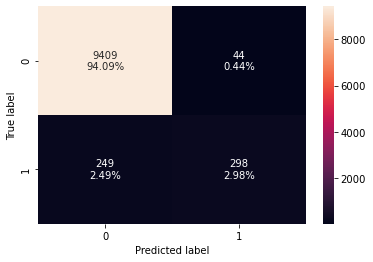

<IPython.core.display.Javascript object>

In [41]:
#Confusion matrix of the final model on test data. 
confusion_matrix_sklearn(model,X_test,y_test)

In [60]:
# Calculating different metrics on validation set
Final_Model = model_performance_classification_sklearn(model, X_test, y_test)
print("Test performance:")
Final_Model

Test performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.989,0.859,0.938,0.897,0.798


<IPython.core.display.Javascript object>

# Business Insights and Conclusions

* The objective was to come up with the best tuned model and apply it on the test data to identify failures so that the generator could be repaired before failing/breaking to keep the maintenance cost minimum.
* We picked Random Forest, Bagging ,GradientBoost classification models among all the models we applied on the training data.
* We tuned these models with the best parameters and applied the tuned models on the validation set of data.
* After collecting all the performance matrices on the tuned classifications modeles we chose the RandomClassifier classification model and applied it on the test data.
* We are able to predict 94.22% of Total Positives ``No Failures" hence Minimum Maintenance cost for these machines.  
* We are able to predict 4.70% of Total Negative with "Failures" so a good estimate of maintenance cost to keep it down.
* We were able to bring down the maintenance cost by minimizing the False Negative and False Positive which is 0.31% and 0.77%.
* The RandomSearchClassifier Classification model was able to predict the maintenance cost with the 98% Accuracy with 80% of Minimum_Vs_Model_cost.
